*JSC270, Winter 2020 - Prof. Chevalier*

# <center>  Assignment 2 - Yelp  </center>

### <center> Samuel Vedrik, 15/02/2020 </center>


***

### Introduction

This report is part of an assignment for the JSC270 course at the University of Toronto. The data set that we will use comes from the [Yelp Dataset Challenge](https://www.yelp.com/dataset/challenge). We will be exploring this data set to gain further insights into the different aspects of Yelp. For the purposes of this analysis, will be using the businesses and reviews portion of this data. 


#### The Dataset

First, we will review the licenses that are granted to us by Yelp regarding usage of the data set provided. The license can be viewed in full [here](https://s3-media1.fl.yelpcdn.com/assets/srv0/engineering_pages/06cb5ad91db8/assets/vendor/yelp-dataset-agreement.pdf).

From section 3, it is clear that we are explicitly granted permission to use the data for academic purposes, which this report is. We are not allowed to use the data in a way that is competitive to Yelp, nor can we use the data for commercial purposes. We are also barred from showing the full contents of the data to the public, as well as using the contents of the analyses to aid third party businesses without Yelp's consent. We also cannot draw any conclusions that may imply that Yelp has created/tampered the data, nor can we tamper/modify the data ourselves. 

With this license in mind, we can begin exploring the yelp data set. 

#### Data Exploration

The dataset is encoded as a JSON file. Each JSON object represents a single entry, and so we must parse through them all in order to extract the information needed. Since these JSON files are large (especially *review.json*, which is more than 5 GB) the function written to extract the information can take in a max parameter, which will specify how many lines are to be read from the file. Let's take a look at an example from the review, business, and user datasets. 


In [714]:
# Imports and setup.

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import scipy.stats as stats
import simplejson as json
import haversine
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
from nltk.corpus import stopwords

plt.rcParams["figure.figsize"] = [15, 7]
plt.style.use('ggplot')

In [2]:
def get_dataframe_from_json(filein, max_=None):
    """
    Reads in the JSON file and converts it into a pandas dataframe. 
    
    filein   : The path to the JSON file
    max_     : The maximum number of lines to be read. The default is to read them all. 
    returns  : The dataframe that represents the JSON. 
    
    Example usage: 
    >>> df = get_dataframe_from_json("yelp_dataset/business.json", 20)
    >>> df_full = get_dataframe_from_json("yelp_dataset/business.json")
    """
    lines = []
    with open(filein) as file:
        if isinstance(max_, int):
            for i in range(max_):
                lines.append(file.readline())
        else:
            lines.extend(file.readlines())
            
    return pd.DataFrame([json.loads(line) for line in lines])

In [715]:
df_b1 = get_dataframe_from_json("yelp_dataset/business.json", 1)
df_b1.head()

business_id                        name  \
0  1SWheh84yJXfytovILXOAQ  Arizona Biltmore Golf Club   

                       address     city state postal_code   latitude  \
0  2818 E Camino Acequia Drive  Phoenix    AZ       85016  33.522143   

    longitude  stars  review_count  is_open                attributes  \
0 -112.018481    3.0             5        0  {'GoodForKids': 'False'}   

          categories hours  
0  Golf, Active Life  None

In [716]:
df_r1 = get_dataframe_from_json("yelp_dataset/review.json", 1)
df_r1.head()

review_id                 user_id             business_id  \
0  Q1sbwvVQXV2734tPgoKj4Q  hG7b0MtEbXx5QzbzE6C_VA  ujmEBvifdJM6h6RLv4wQIg   

   stars  useful  funny  cool  \
0    1.0       6      1     0   

                                                text                 date  
0  Total bill for this horrible service? Over $8G...  2013-05-07 04:34:36

In [717]:
df_u1 = get_dataframe_from_json("yelp_dataset/user.json", 1)
df_u1.head()

user_id    name  review_count        yelping_since  useful  \
0  l6BmjZMeQD3rDxWUbiAiow  Rashmi            95  2013-10-08 23:11:33      84   

   funny  cool           elite  \
0     17    25  2015,2016,2017   

                                             friends  fans  ...  \
0  c78V-rj8NQcQjOI8KP3UEA, alRMgPcngYSCJ5naFRBz5g...     5  ...   

   compliment_more  compliment_profile  compliment_cute  compliment_list  \
0                0                   0                0                0   

   compliment_note  compliment_plain  compliment_cool  compliment_funny  \
0                1                 1                1                 1   

   compliment_writer  compliment_photos  
0                  2                  0  

[1 rows x 22 columns]

It seems that each user, review, and business has an ID that we can search up. Each ID is 22 character long string that includes alpha-numeric characters, underscores and hyphens. That is a total possibility of $22^{64}$ unique combinations, or 8 followed by 85 zeroes. Considering that the number of atoms in the universe is roughly 1000 times smaller than this number, we can safely assume each ID will be unique. 

Lets take a look at the different fields of each file.

In [718]:
def print_columns(data, name):
    """
    Prints the columns of data and it's name. 
    """
    print("The {} fields for {}:".format(data.shape[1], name))
    [print(col, end=" | ") for col in list(data.columns)[:-1]]
    print(list(data.columns)[-1] + "\n")

print_columns(df_u1, "user")
print_columns(df_b1, "business")
print_columns(df_r1, "review")

The 22 fields for user:
user_id | name | review_count | yelping_since | useful | funny | cool | elite | friends | fans | average_stars | compliment_hot | compliment_more | compliment_profile | compliment_cute | compliment_list | compliment_note | compliment_plain | compliment_cool | compliment_funny | compliment_writer | compliment_photos

The 14 fields for business:
business_id | name | address | city | state | postal_code | latitude | longitude | stars | review_count | is_open | attributes | categories | hours

The 9 fields for review:
review_id | user_id | business_id | stars | useful | funny | cool | text | date



We can also take a look at the [official documentation](https://www.yelp.com/dataset/documentation/main) to get a better understanding of each of the different fields and files, as well as the format of each of the data. For example, we can use the documentation to realize that for the "is_open" field, 0 means closed and 1 means open. 

## Businesses

With a deeper understanding of the data that we are working with, lets explore the **business** dataset. During the exploration, individual observations will be shortened to only include the name, city, state and stars, and I will include the other data if it is relevant. This is to prevent the document from being too wide. 

**Cities** 

We will start by exploring the different cities that are included in the dataset. Let's take a look at some basic statistics first:

In [7]:
df_business = get_dataframe_from_json("yelp_dataset/business.json")
bus_simple = ["name", "city", "state", "stars"]

In [719]:
print("There are {} unique cities listed in the business dataset.".format(len(df_business["city"].unique())))

There are 1204 unique cities listed in the business dataset.


We can take a look at the top 5 cities recorded in the dataset:

In [9]:
df_business_cities= pd.DataFrame(df_business["city"].value_counts())
df_business_cities = df_business_cities.reset_index().rename(columns={"index":"City", "city":"Count"})
df_business_cities.head(5)

City  Count
0   Las Vegas  29370
1     Toronto  18906
2     Phoenix  18766
3   Charlotte   9509
4  Scottsdale   8837

Most of the cities above are popular tourist destinations, such as Las Vegas, Toronto and Phoenix. However, most of the top cities that are expected to be the top are not prevalent, such as New York City, Vancouver, or Boston. We can investigate these further. 

In [10]:
print("List of cities in NY:")
print(df_business[df_business["state"] == "NY"]["city"].unique())

List of cities in NY:
['Champlain' 'Rouses Point' 'Brooklyn' 'Closter' 'New York'
 'North Las Vegas' 'Mooers']


In [11]:
df_business[df_business["city"] == "Boston"][bus_simple]

name    city state  stars
192303  Trailside Treasures  Boston    PA    4.5

Upon further investigation, it seems that some popular cities are not listed in the yelp dataset. The aforementioned cities (New York City NY, Vancouver BC, Boston MA) are not mentioned. There was one instance of Boston, however after some [research](https://en.wikipedia.org/wiki/Boston,_Pennsylvania) I discovered that it was a small town in Pennsylvania. Therefore, after this discovery, we cannot assume that this yelp dataset encompasses the entire USA/Canada, and therefore any conclusions made are limited to cities that are listed here. 

Conversely, we can take a look at cities that have only 1 listing. 

In [12]:
print("There are {} cities that have only one listing, which is {:.2f}% of cities in the dataset.".format(
    df_business_cities[df_business_cities["Count"] == 1].shape[0], 
    (df_business_cities[df_business_cities["Count"] == 1].shape[0]) / (df_business_cities.shape[0]) * 100
))

There are 535 cities that have only one listing, which is 44.44% of cities in the dataset.


That is a suspiciously large percentage of the listings. After some investigation, I can notice 5 different causes to this. 

1) The city is a small, and thus have very little listings in yelp. The aforementioned Boston, PA is one of them. 

2) There are misspellings of the city name. For example, one business listed their city as "Mississauaga" instead of "Mississauga" (Notice the extra 'a' before the 'g'). Another business listed their city as "Gelndale" instead of "Glendale". 

3) They mistakenly used the state name as their city. One business listed their city as "Alberta", which is a state. 

4) They used an alternative name / were too specific. For example, one business used "West Montreal" instead of  Montreal, and another used "N E Las Vegas" instead of Las Vegas. 

5) They added a comma after the city name. 

In [13]:
df_business[df_business["city"] == "Mississauaga"][bus_simple]

name          city state  stars
137513  YogaVision  Mississauaga    ON    5.0

In [14]:
df_business[df_business["city"] == "Alberta"][bus_simple]

name     city state  stars
6834  Hooters  Alberta    AB    2.5

In [15]:
df_business[df_business["city"] == "N E Las Vegas"][bus_simple]

name           city state  stars
78405  Lowe's Home Improvement  N E Las Vegas    NV    4.0

In [16]:
df_business[df_business["city"] == "Las Vegas,"][bus_simple]

name        city state  stars
74494  Nsight Tactical  Las Vegas,    NV    5.0

After digging for a while, there are a few interesting cases. One listing had nothing listed as the city, while another simply had "SURPRISE" for their city name. 

In [17]:
df_business[df_business["city"] == "SURPRISE"][bus_simple]

name      city state  stars
12574  Discount Tire  SURPRISE    AZ    4.0

Surprisingly, [Surprise, AZ](https://en.wikipedia.org/wiki/Surprise,_Arizona) is a real place. 

With that said, there are more than 150,000 businesses in the yelp dataset, and there are only 535 entries with a misspelled city. We can set a city to be legitimate/important for this analysis if at least 10 business have the city listed. This number was an arbitrary choice, as 10 seemed like a good cutoff. We can see how many entries are left after we have applied this filter.

In [18]:
# Filters out business that are not in "valid", and stores it into a new dataframe.
valid_cities = df_business_cities[df_business_cities["Count"] >= 10].loc[:, "City"].values

def is_valid(city):
    return city in valid_cities

df_business_cut = df_business[df_business["city"].apply(lambda x: is_valid(x))].copy()

In [19]:
loss = df_business.shape[0] - df_business_cut.shape[0]

print("There are {} business that are cut off from this filter, which is {:.3f}% of businesses.".format(
    loss, loss*100 / df_business.shape[0]))

There are 1792 business that are cut off from this filter, which is 0.930% of businesses.


There is barely 1% of business that do not make the cutoff. This amount seems reasonable, and thus we will continue our analysis with the filtered dataset. 

We can plot the location of the listings and see where the majority of yelp listings are located. 

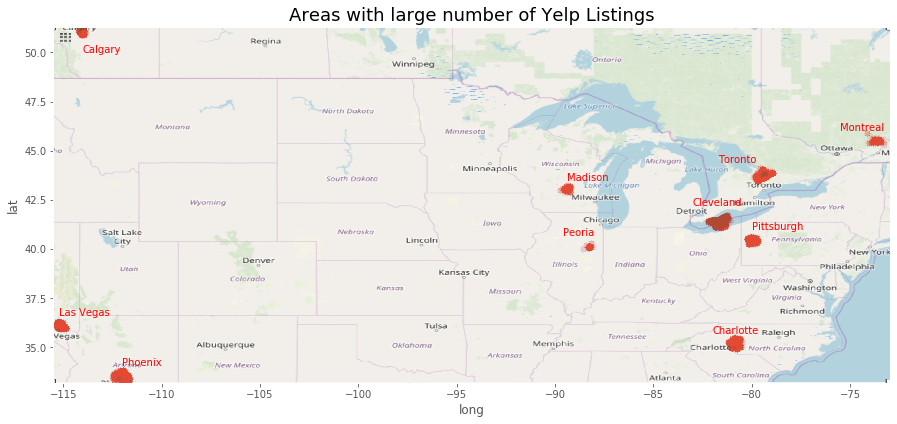

In [729]:
boundaries = (df_business_cut["longitude"].min(), df_business_cut["longitude"].max(), 
             df_business_cut["latitude"].min(), df_business_cut["latitude"].max())

plt.scatter(df_business_cut["longitude"], df_business_cut["latitude"], alpha=0.005)
plt.xlim(boundaries[0], boundaries[1])
plt.ylim(boundaries[2], boundaries[3])
plt.xlabel("long")
plt.ylabel("lat")

map_ = plt.imread("./images/business_map_all.png")
im = plt.imshow(map_, zorder=0, extent=boundaries, aspect="equal")
tit = plt.title("Areas with large number of Yelp Listings", fontsize=18)
plt.grid(linestyle="")


# Plots the labels of each area
plt.text(-112, 34.1, "Phoenix", color="red")
plt.text(-115.2, 36.6, "Las Vegas", color="red")
plt.text(-114,  50, "Calgary", color="red")
plt.text(-82, 35.7, "Charlotte", color="red")
plt.text(-80, 41, "Pittsburgh", color="red")
plt.text(-83, 42.2, "Cleveland", color="red")
plt.text(-89.4, 43.5, "Madison", color="red")
plt.text(-89.6, 40.7, "Peoria", color="red")
plt.text(-81.7, 44.4, "Toronto", color="red")
txt = plt.text(-75.5, 46, "Montreal", color="red")

Although the map above is not 100% accurate/aligned, we can still use it to pinpoint that there are 10 major areas that have a high amount of yelp listings. To help visualization, I labelled the name of the large areas in red. Areas that are not included in the map do not contain any listings. 

Several top cities are nearby, such as Phoenix and Scottsdale, and thus they appear as one large dot. I considered them to be one city. Therefore, the top 10 cities might not correlate the the 10 different spots above. For example, Peoria is only the 18th city in relation to number of listings.

When the transparency is set to 1, I noticed that there is a small dot in arkansas. We can take a look at these outliers.

In [21]:
df_business_cut[df_business_cut["state"] == "AR"]

business_id        name        address        city state  \
164784  TsVB0NJw7a5r0NHlZW9IWg  McDonald's  369 Hwy 425 N  Monticello    AR   

       postal_code   latitude  longitude  stars  review_count  is_open  \
164784       71655  33.635577 -91.802155    2.0             7        1   

                                               attributes  \
164784  {'RestaurantsReservations': 'False', 'GoodForK...   

                                               categories  \
164784  Coffee & Tea, Food, Fast Food, Restaurants, Bu...   

                                                    hours  
164784  {'Monday': '0:0-0:0', 'Tuesday': '0:0-0:0', 'W...

After searching for businesses with the state "AR", the only result is a McDonald's. It's interesting to note that this McDonald's is barely average. After some investigation, it appears that there are two spellings of McDonald's: one with the apostrophe and one without. There is also one McDonald's with additional information : McDonald's - MGM Grand The District Food Court. We can use regex to fix this issue. 

After a forture accident, I discovered an additional variation: one where the D is lower case: Mcdonalds and Mcdonald's. Luckily, a quick fix to the regex helped solve the issue. 

In [22]:
print("The average star rating for all McDonald's is: {:.3f}".format(
    df_business_cut[df_business_cut["name"].str.match("Mc[D|d]onald'?s")]["stars"].mean()
))

The average star rating for all McDonald's is: 2.043


**Categories**

Next, we can take a look at the categories field. Each list of category in the categories variable is a string, and they each unique category is separated by a comma. We can create sets for each list of catagories, and union them all to get all the unique categories in the dataset. 

In [24]:
df_categories = df_business_cut["categories"].dropna().apply(lambda x: set(x.split(", ")))
categories = set()
for cat in df_categories:
    categories = categories.union(cat)

In [25]:
print("There are {} unique categories.".format(len(categories)))

There are 1300 unique categories.


In [26]:
df_business_cut["categories_set"] = df_business_cut["categories"].apply(
    lambda x: set(x.split(", ")) if x is not None else set()).copy()

Using this method also counts "Pizza, Restaurants" and "Restaurants, Pizza" the same, so we can accurately count the number of unique category combinations. We will list the top 5 category combinations. 

In [27]:
df_business_cut["categories_set"].value_counts().head()

{Restaurants, Pizza}                        1990
{Home Services, Real Estate, Apartments}    1974
{Nail Salons, Beauty & Spas}                1972
{Coffee & Tea, Food}                        1737
{Restaurants, Mexican}                      1732
Name: categories_set, dtype: int64

Pizza joints are the most popular business in the yelp dataset. Surpringly, "Mexican" and "Restaurants" is the 5th most popular unique business category combination in the yelp dataset. We can investigate the cause a little further. My hypothesis is that since there are a large portion of listings are listed in Arizona, which is close to the southern border, there are more Mexican Restaurants. We can use p-value testing to verify this. 

In [28]:
mexican_filter = df_business_cut["categories_set"] == set(["Restaurants", "Mexican"])
arizona_filter = df_business_cut["state"] == "AZ"

mexican_arizona = \
df_business_cut[(mexican_filter) & arizona_filter].shape[0]

mexican_total = \
df_business_cut[mexican_filter].shape[0]

print("{:.3f}% of businesses with {{'Mexican', 'Restaurants'}} as the category "
      "are in Arizona.".format(mexican_arizona* 100/ mexican_total))

total_arizona = \
df_business_cut[arizona_filter].shape[0]

total_total = \
df_business_cut.shape[0]

print("{:.3f}% of listings are in Arizona.".format(total_arizona*100/total_total))


40.935% of businesses with {'Mexican', 'Restaurants'} as the category are in Arizona.
29.630% of listings are in Arizona.


In [29]:
# NULL HYPOTHESIS: The ratio of Mexican Restaurants in Arizona is about 0.3

REPITITIONS = 1000
SIZE = mexican_total
generated_data = []

for i in range(REPITITIONS):
    sample = df_business_cut.sample(SIZE)
    filter_1 = sample["state"] == "AZ"
    generated_data.append(sample[filter_1].shape[0] / sample.shape[0])

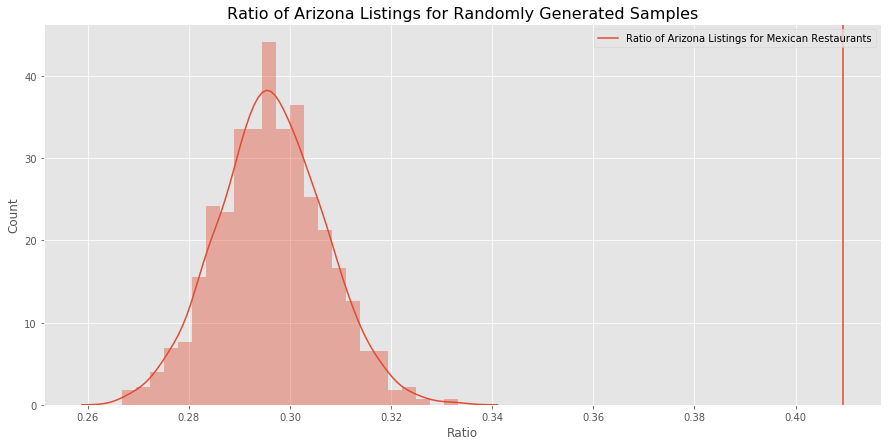

In [730]:
sns.distplot(generated_data)
plt.title("Ratio of Arizona Listings for Randomly Generated Samples", fontsize=16)
plt.ylabel("Count")
plt.xlabel("Ratio")
plt.axvline(x=(mexican_arizona/mexican_total), label="Ratio of Arizona Listings for Mexican Restaurants",
            linestyle="-")
leg = plt.legend(loc=1)

As we can see from the graph above, we can say confidently that a large ratio of Mexican Restaurants are listed in Arizona. This confirms our hypothesis. This makes geographic sense, as there are more mexican tourists / residents as you get closer to the southern border, so the demand for mexican restaurants increase. The cultures also start to be more mixed to closer we get to the southern border, which might also be a factor to the large ratio of Mexican Restaurants. 

This analysis has a limitation in that we did not consider Mexican Restaurants that might have other categories listed, and only looked at businesses that strictly have "Restaurants" and "Mexican" in their categories. Parsing through all possible combinations that mexican restaurants may have will take more processing power/time than I possess, although I might consider expanding this analysis in the future. 

In the future, we can confirm the hypothesis of the why this is the case with census data that shows the amount of people that identify as latino or mexican for each region. This might be potentially unethical however, as it might be a breach of privacy if done poorly. 

Next, we can investigate the number of businesses that included each category in their listing. 

In [720]:
def get_num_cat(data, cat):
    """
    Gets the number of businesses that has listed category cat in their categories in data.
    """

    return (data["categories_set"].apply(lambda x : cat in x)).sum()

In [721]:
# categories_count = []

# for cat in categories:
#     n = (df_business_cut["categories_set"].apply(lambda x : cat in x)).sum()
#     categories_count.append((n, cat))

categories_count = [(get_num_cat(df_business_cut, cat), cat) for cat in categories]
categories_count.sort(reverse=True, key=lambda x: x[0])

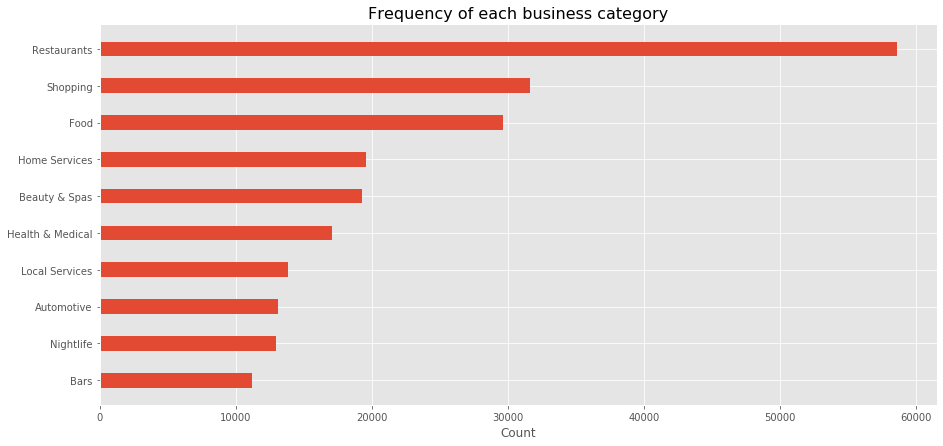

In [731]:
NUM_TO_SHOW = 10

y_pos = [2*i for i in range(10)][::-1]

plt.barh(y_pos, [x[0] for x in categories_count[:NUM_TO_SHOW]])

ticks = plt.yticks(y_pos, [x[1] for x in categories_count[:NUM_TO_SHOW]])

plt.title("Frequency of each business category", fontsize=16)
lbl = plt.xlabel("Count")

We can see from the above graph that restaurants are by far the most frequent business category for the Yelp Dataset, with shopping as second most frequent business category. It's interesting to note that "Restaurant" and "Food" are classified as two different things. 

From [this documentation page](https://www.yelp.ca/developers/documentation/v3/category_list), "Food" are for foodtrucks, cafes, dessert shops, etc. It is fair to classify "Restaurants" as something different from the rest of the "Food" category, so for this analysis we will treat the two separately. 

We can also find out which categories are the least mentioned. 

In [723]:
df_categories = pd.DataFrame(categories_count)[[1, 0]].copy().rename(columns={1:"Category", 0:"Count"})
niche_categories = df_categories[df_categories["Count"] <= 1]["Category"].values

print("The following have only 1 business that are listed in that category.")
for item in niche_categories:
    print(item, end=" | ")

The following have only 1 business that are listed in that category.
Geneticists | Tempura | Halfway Houses | Bulgarian | Rotisserie Chicken | Christmas Markets | Toxicologists | Czech/Slovakian | Drive-Thru Bars | Calligraphy | Island Pub | Soba | DUI Schools | Rodeo | General Festivals | Entertainment Law | Ceremonial Clothing | Sport Equipment Hire | Calabrian | Studio Taping | Tonkatsu | Backshop | Minho | Japanese Sweets | Sauna Installation & Repair | Customs Brokers | Senegalese | Oaxacan | Homeopathic | Osteopaths | Street Art | Game Meat | Experiences | Hainan | Market Stalls | Eastern European | Beer Hall | Hang Gliding | Bocce Ball | Otologists | Court Reporters | Medical Foot Care | Udon | Milkshake Bars | Dialysis Clinics | Churros | Beach Volleyball | 

It seems that the least mentioned categories are categories that are in fact niche (such as Senegalese), or are very specific (Udon/Tempura/Island Pub). It is interesting to note that during the search I found out that there are two listings with the "Nudist" category. I had to investigate, of course.  

In [34]:
nudist_filter = df_business_cut["categories_set"].apply(lambda x : "Nudist" in x)
df_business_cut[nudist_filter][bus_simple]

name       city state  stars
128344               The Royal Villa    Phoenix    AZ    4.0
146662  Sea Mountain One Love Temple  Las Vegas    NV    4.0

Let's take a look the full categories that each of them listed.

In [724]:
def print_categories(data):
    """
    Prints the categories of the given business. 
    """
    print("{} has the following as their categories:".format(data["name"]))
    for cat in data["categories_set"]:
        print(cat, end=" | ")
        
print_categories(df_business_cut[nudist_filter].iloc[0])
print("\n")
print_categories(df_business_cut[nudist_filter].iloc[1])

The Royal Villa has the following as their categories:
Active Life | Hotels & Travel | Hotels | Local Flavor | Nudist | Event Planning & Services | 

Sea Mountain One Love Temple has the following as their categories:
Active Life | Religious Organizations | Nightlife | Dance Clubs | Beauty & Spas | Social Clubs | Bars | Arts & Entertainment | Lounges | Nudist | Adult Entertainment | Buddhist Temples | Day Spas | 

It's quite interesting that "Sea Mountain One Love Temple" listed their business as a religious organization. After a quick google search, I discovered that it is indeed a nude resort in Las Vegas. After this brief detour, let's continue with our analysis. 

Amongst the restaurants, let's find out which cuisine is the most popular. 

In [725]:
restaurant_filter = df_business_cut["categories_set"].apply(lambda x : "Restaurants" in x)
df_restaurants = df_business_cut[restaurant_filter]
# restaurant_cuisines = []
# for cat in categories:
#     n = df_restaurants["categories_set"].apply(lambda x: cat in x).sum()
#     if n != 0:
#         restaurant_cuisines.append((n, cat))
restaurant_cuisines = [(get_num_cat(df_restaurants, cat), cat) for cat in categories]
restaurant_cuisines.sort(reverse=True, key = lambda x: x[0])

In [726]:
restaurant_cuisines = restaurant_cuisines[1:]

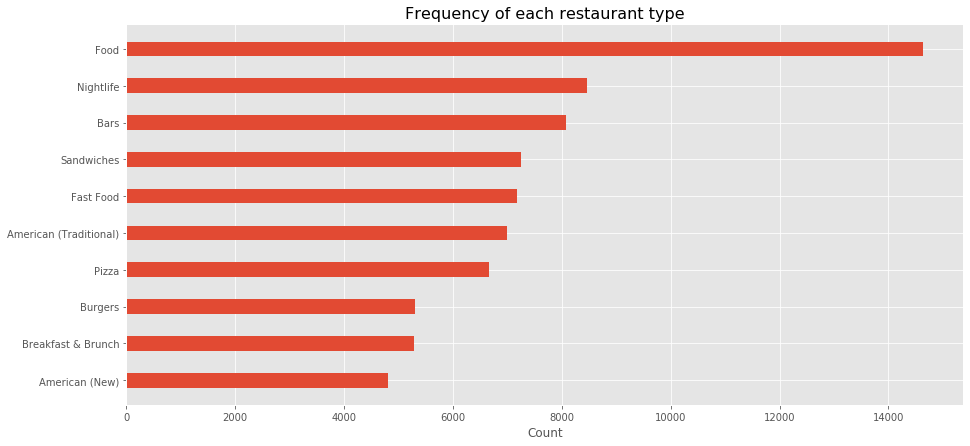

In [732]:
NUM_TO_SHOW = 10

y_pos = [2*i for i in range(10)][::-1]

plt.barh(y_pos, [x[0] for x in restaurant_cuisines[:NUM_TO_SHOW]])

ticks = plt.yticks(y_pos, [x[1].strip() for x in restaurant_cuisines[:NUM_TO_SHOW]])

plt.title("Frequency of each restaurant type", fontsize=16)
lbl = plt.xlabel("Count")

We can see that a large portion of Restaurants also include "Nightlife" and "Bars". This might be due to the influence of having Las Vegas being a large portion of the data set. It's also interesting to see how fast food and burgers are some of the most popular restaurants. It's interesting to see how many of them comes from McDonald's.

In [39]:
burger_filter = df_restaurants["categories_set"].apply(lambda x : "Burgers" in x)
fast_food_filter = df_restaurants["categories_set"].apply(lambda x : "Fast Food" in x)
mcd_n = df_restaurants[df_restaurants["name"].str.match("Mc[D|d]onald'?s")].shape[0]
burger_n = df_restaurants[burger_filter].shape[0]
fast_food_n = df_restaurants[fast_food_filter].shape[0]

print("There are {} McDonalds out of {} burger restaurants, which is {:.1f}% of burger restaurants".format(
    mcd_n, burger_n, mcd_n*100/burger_n))

print("There are {} McDonalds out of {} fast food restaurants, which is {:.1f}% of fast food restaurants".format(
    mcd_n, fast_food_n, mcd_n*100/fast_food_n))

There are 819 McDonalds out of 5306 burger restaurants, which is 15.4% of burger restaurants
There are 819 McDonalds out of 7180 fast food restaurants, which is 11.4% of fast food restaurants


Are fast food joins the majority of all burger restaurants?

In [40]:
b_ff_n = df_restaurants[(burger_filter) & (fast_food_filter)].shape[0]

print("Out of {} burger restaurants, {} are fast food restaurants as well, which is {:.1f}% of them.".format(
burger_n, b_ff_n, b_ff_n*100/burger_n))

Out of 5306 burger restaurants, 2294 are fast food restaurants as well, which is 43.2% of them.


Surprisingly enough, fast food restaurants do not hold the majority of burger restaurants! We can check the contrapositive. Do fast food restaurants mostly sell burgers? 

In [41]:
print("Out of {} fast food restaurants, {} sell burgers, which is {:.1f}% of them.".format(
fast_food_n, b_ff_n, b_ff_n*100/fast_food_n))

Out of 7180 fast food restaurants, 2294 sell burgers, which is 31.9% of them.


Again, only about 32% of fast food joints sell burgers.

We can check the hypothesis that "Nightlife" and "Bar" are prominent due to Las Vegas being a large portion of the dataset by checking the portion of "Nightlife" and "Bar" restaurants that are located in Las Vegas. 

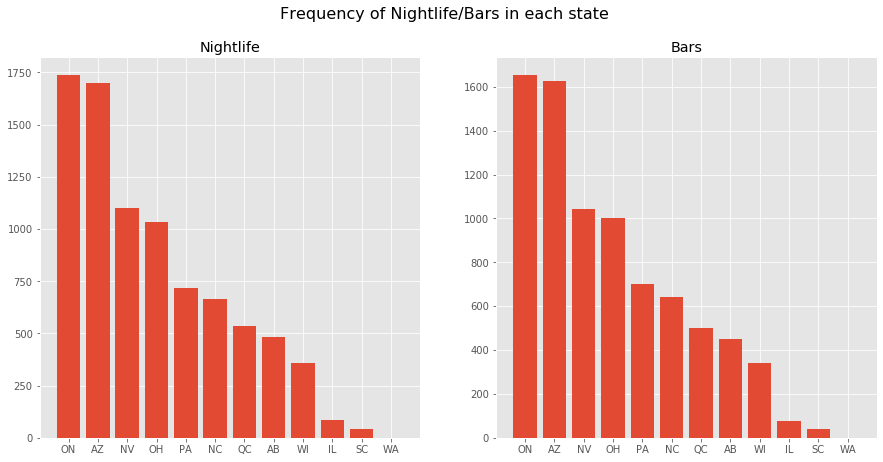

In [42]:
nightlife_filter = df_restaurants["categories_set"].apply(lambda x : "Nightlife" in x)
bar_filter = df_restaurants["categories_set"].apply(lambda x : "Bars" in x)

fig, ax = plt.subplots(1, 2)
nightlife_count = df_restaurants[nightlife_filter]["state"].value_counts()
bar_count = df_restaurants[bar_filter]["state"].value_counts()

ax[0].bar(nightlife_count.index, nightlife_count.values)
ax[1].bar(bar_count.index, bar_count.values)
ax[0].set_title("Nightlife")
ax[1].set_title("Bars")

tit = fig.suptitle("Frequency of Nightlife/Bars in each state", fontsize=16)

From the graphs above, we can clearly see that my hypothesis was wrong. In fact, most of the Nightlife/Bar restaurants are located in Ontario and Arizona. Nevada (The state with Las Vegas) is a distant third from the aforementioned two states. 

**Bike Parking** 

Next, we will explore **attributes** field, specifically bike parking. We are interested to see what factors lead to highest possibility of having bike parking. Before we begin the analysis however, we need to get acquainted with the attributes field and perform some basic exploration.  

Each cell in the attributes field is a dictionary of various lengths. This means that not all attributes are listed in each business, so we have to be careful with key errors. First, let's take a look at all the different attributes. 

In [43]:
attributes_keys = set()

for attr in df_business_cut["attributes"]:
    attributes_keys = attributes_keys.union(set(attr.keys()) if attr is not None else set())

print("There are {} possible attributes.".format(len(attributes_keys)))

There are 39 possible attributes.


Next, we can take a look at the number of businesses that have the "Bike Parking" attribute, the possible values they might have, and the distribution of those values. 

In [44]:
bike_filter = df_business_cut["attributes"].apply(lambda x :"BikeParking" in x if x is not None else False)
n_bike = bike_filter.sum()

values = []
for attr in df_business_cut[bike_filter]["attributes"]:
    values.append(attr["BikeParking"])
    values = list(set(values))

print("There are {} datapoints with the 'Bike Parking' attribute.\n".format(n_bike))

print("The following are the possible values for the 'Bike Parking' attribute:")
for value in values:
    print(value, end=" | ")
    


There are 84618 datapoints with the 'Bike Parking' attribute.

The following are the possible values for the 'Bike Parking' attribute:
False | None | True | 

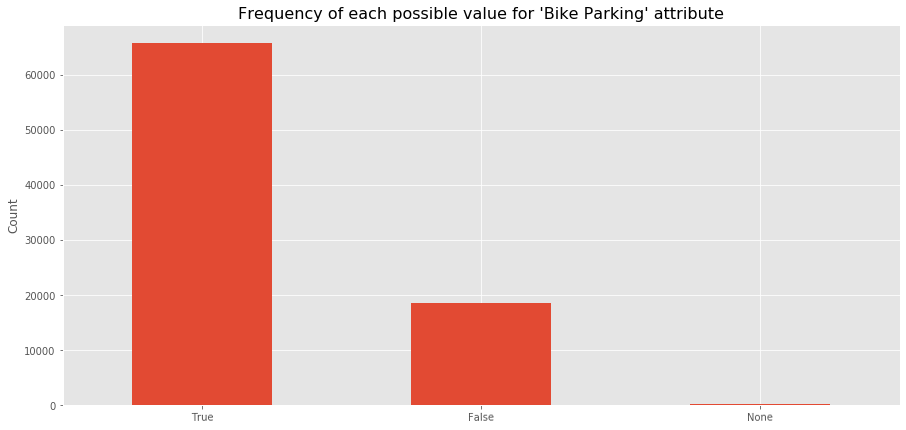

In [733]:
df_business_cut[bike_filter]["attributes"].apply(lambda x : x["BikeParking"]).value_counts().plot.bar(rot=1)
plt.title("Frequency of each possible value for 'Bike Parking' attribute", fontsize=16)
lbl = plt.ylabel("Count")

During the exploration above, I discovered that the values are not represented as booleans, but as strings. There are also a very small number of "None", which we can eliminate for this analysis. We will create a new dataframe that only contains businesses that have the "Bike Parking", convert the string value into booleans, and add a new variable to store that value. 

In [46]:
# Creates the bike parking dataframe

df_bike_parking = df_business_cut[bike_filter].copy()
df_bike_parking["Bike_Parking"] = df_bike_parking["attributes"].apply(
    lambda x : x["BikeParking"])
df_bike_parking["Bike_Parking"].replace({"True": True, "False": False, "None": np.nan}, inplace=True)
df_bike_parking = df_bike_parking[~df_bike_parking["Bike_Parking"].isna()]

First, let's see if there is any correlation between star rating and whether or not the business offers bike parking.  

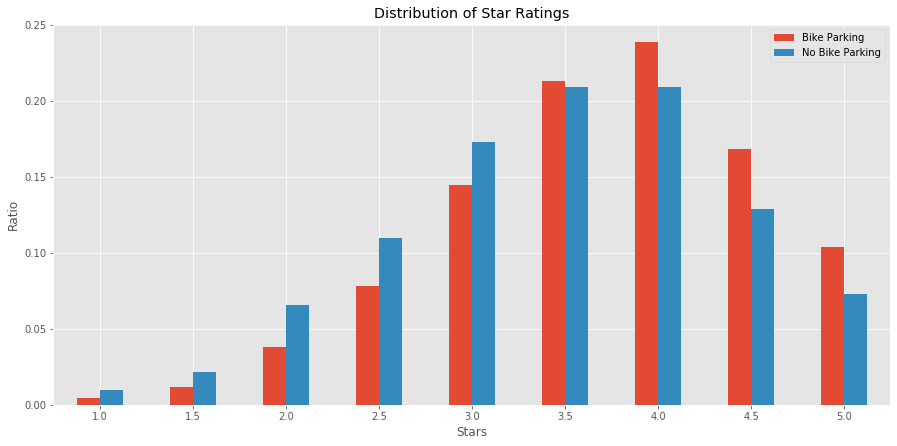

In [47]:
has_bike = df_bike_parking["Bike_Parking"] == True


bike_stars = df_bike_parking[has_bike]["stars"].value_counts(normalize=True).sort_index()
no_bike_stars = df_bike_parking[~has_bike]["stars"].value_counts(normalize=True).sort_index()

pd.DataFrame({"Bike Parking": bike_stars.values, "No Bike Parking": no_bike_stars.values}, 
             index=bike_stars.index).plot.bar(rot=1)
plt.title("Distribution of Star Ratings")
lbl = plt.ylabel("Ratio"), plt.xlabel("Stars")

The distribution of the stars for businesses that offer bike parking and no bike parking are very similar, so we can safely assume that star ratings have no correlation to whether a business offers bike parking. 

Next, let's take a look at the distribution of business categories that offer bike parking, and compare it to the entire dataset. 

In [48]:
# categories_bike = []

# for cat in categories:
#     n = (df_bike_parking[has_bike]["categories_set"].apply(lambda x : cat in x)).sum()
#     categories_bike.append((n, cat))

categories_bike = [(get_num_cat(df_bike_parking[has_bike], cat), cat) for cat in categories]    
categories_bike.sort(reverse=True, key=lambda x: x[0])

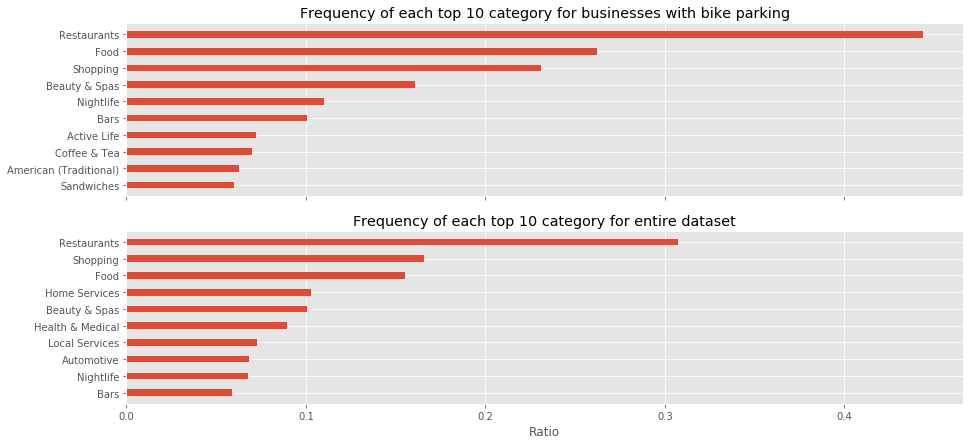

In [49]:
NUM_TO_SHOW = 10
num_bike = has_bike.sum()
num_total = df_business_cut.shape[0]

fig, ax = plt.subplots(2, 1, sharex=True)

y_pos = [2*i for i in range(10)][::-1]

ax[0].barh(y_pos, [x[0]/num_bike for x in categories_bike[:NUM_TO_SHOW]])
ax[1].barh(y_pos, [x[0]/num_total for x in categories_count[:NUM_TO_SHOW]])

ax[0].set_yticks(y_pos)
ax[0].set_yticklabels([x[1] for x in categories_bike[:NUM_TO_SHOW]])
ax[1].set_yticks(y_pos)
ax[1].set_yticklabels([x[1] for x in categories_count[:NUM_TO_SHOW]])

ax[0].set_title("Frequency of each top 10 category for businesses with bike parking")
ax[1].set_title("Frequency of each top 10 category for entire dataset")



lbl = plt.xlabel("Ratio")

The plot above shows that the ratio of restaurants is higher for businesses that offer bike parking compared to all the businessses in the dataset. We can also see that Home Services, Health & Medical, Local Services and Automotive  categories are present one of the top 10 categories for the entire dataset, but are absent in the top 10 categories for businesses that offer bike parking. 

Therefore, we can conclude that Home Services, Health & Medical, Local Services and Automotive business tend to not offer bike parking. These are often business that do not expect customers to arrive on bike, so it is rational for them to not offer bike parking. Likewise, some restaurants would expect customers to arrive on bike, so they tend to offer parking for bikes. 

Next, we can take a look at the distribution of states that offer bike parking, and compare it to the entire dataset, similar to the last analysis. 

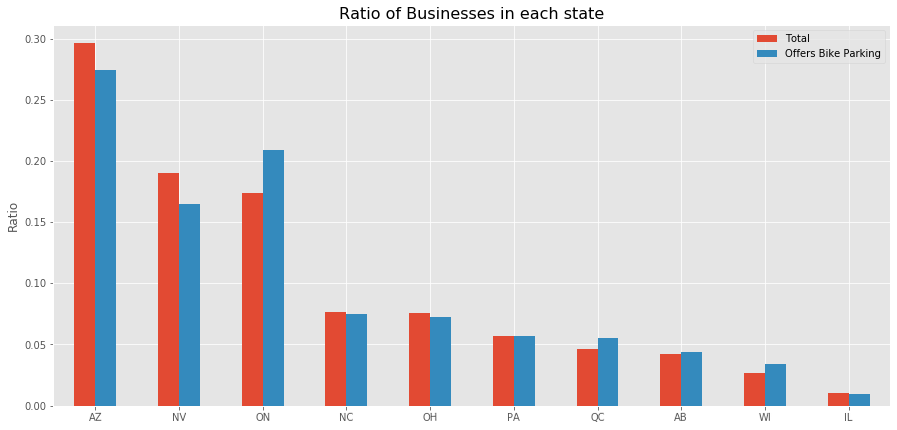

In [734]:
bike_states = df_bike_parking[has_bike]["state"].value_counts(normalize=True).head(10).sort_index()
total_states = df_business_cut["state"].value_counts(normalize=True).head(10).sort_index()

states_df = pd.DataFrame({"Total" : total_states.values, "Offers Bike Parking": bike_states.values},
                         index=bike_states.index)

states_df.sort_values(by="Total", ascending=False).plot.bar(rot=1)

text = plt.title("Ratio of Businesses in each state", fontsize=16)
lbl = plt.ylabel("Ratio")

From the graph above, we see that there are a larger ratio of businesses offering parking that are located in ontario compared to the entire dataset, and both Arizona and Nevada have less. In general, all of the canadian states and Wisconsin have higher ratios, while southern states have smaller ratios. 

This might be due to the fact that southern states have hotter climates and are less dense, which may make bike riding less comfortable and cars more preferable, and thus lead to a smaller number of bike riders and thus less demand for bike parking. Conversely, northern states are more bike friendly and have colder climates, which lead to a larger number of bike riders and more demand for bike parking. 

Next, let's investigate the following: Do restaurant prices affect bike parking? 

My hypothesis is yes, as the price range increases, it is less likely that the restaurants will offer bike parking. This is because higher end restaurants do not expect customers to arrive on bike, so they will tend to not offer bike parking. 

We can find the price range of the restaurants by using the "RestaurantsPriceRange2" key in the attributes, if the business included one. They are listed as an integer from 1 to 4. From [this forum question](https://www.yelp.com/topic/mesa-what-is-latest-definition-and-range-of-the-dollar-sign-on-yelp-for-actual-expense) and some further research, these price ranges are collected from reviewers as part of the survey. 

* 1 means below \\$10
* 2 means between \\$11 and \\$30
* 3 means between \\$31 and \\$60
* 4 means more than \\$61

The above is for price per person. Because these price ranges are input from customers, we cannot guarantee that there is no tampering of data. Different users may also intrepret it differently, as some might consider it to be before tax+tip or after tax+tip. For this analysis however, we will assume that the data is accurate enough for usage.

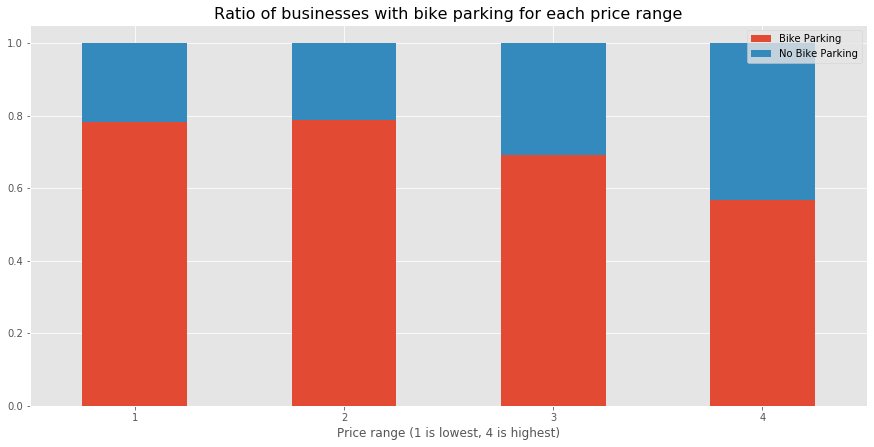

In [735]:
def get_price_counts(data):
    """
    Returns the count of each price range in data.
    """
    filter_ = data["attributes"].apply(lambda x : "RestaurantsPriceRange2" in x if x is not None else False)
    df_temp = data[filter_].copy()
    df_temp["Restaurant_Price"] = df_temp["attributes"].apply(lambda x : x["RestaurantsPriceRange2"])
    return df_temp["Restaurant_Price"].value_counts().sort_index()

bike_rest_prices = get_price_counts(df_bike_parking[has_bike])
no_bike_rest_prices = get_price_counts(df_bike_parking[~has_bike])

prices_df = pd.DataFrame({"Bike Parking": bike_rest_prices.values, "No Bike Parking": no_bike_rest_prices.values},
                        index = bike_rest_prices.index)
prices_df = prices_df.drop("None")

# Creates Ratios
for i in range(4):
    prices_df.iloc[i] = prices_df.iloc[i].apply(lambda x : x/prices_df.iloc[i].sum())

prices_df.plot.bar(stacked=True, rot=1)

plt.title("Ratio of businesses with bike parking for each price range", fontsize=16)
lbl = plt.xlabel("Price range (1 is lowest, 4 is highest)")

From the graph above, we can see that as the price range increases, the ratio of businesses that do not offer bike parking increases. This implies that the hypothesis stated above might be true. There are some limitations to this conclusion, as there are muliple businesses that do not state their bicycle parking availability, and this might introduce some bias.

**Ratings and Number of Reviews**

Finally, we take a look at the ratings and number of reviews businesses have. We will be investigating the following claim: The more reviews there are, the higher the rating, and the more sales there are. 

We will be using the **checkin** dataset for this analysis. We will use the assumption that the checkins have a positive correlation with sales, and thus the number of checkins will be our measurement of sales. 

From  [the official support center web page](https://www.yelp-support.com/article/What-are-Check-Ins?l=en_US), we can see that check ins are defined as when a user updates their friends/public that they have visited a certain restaurant. The checkin data set has two fields, business_id and date, which is a list of dates of individual checkins stored a string where each date is separated by a comma. We can use the business_id to link these two datasets together. 

We will create a new field called "num_checkins", and it stores the number of checkins that the business has. 

In [52]:
df_checkins = get_dataframe_from_json("./yelp_dataset/checkin.json")

In [53]:
# Creates new dataframe for businesses with checkins. 

df_checkins["num_checkins"] = df_checkins["date"].apply(lambda x : len(x.split(", ")))
df_business_checkins = df_business_cut.copy()
df_business_checkins.set_index("business_id", inplace=True)
df_checkins.set_index("business_id", inplace=True)
df_business_checkins = df_business_checkins.merge(df_checkins, on="business_id")

In [54]:
print("There are {} datapoints in the new dataframe.".format(df_business_checkins.shape[0]))

There are 160463 datapoints in the new dataframe.


First, let's take a look at the distribution and summary statistics of checkins. 

In [55]:
pd.DataFrame(df_business_checkins["num_checkins"]).describe()

num_checkins
count  160463.000000
mean      118.591077
std       736.943732
min         1.000000
25%         5.000000
50%        17.000000
75%        65.000000
max    143061.000000

We can see from the max that there are extreme outliers. The max is 2200 times greater than the 75th quantile. This outlier is so large that is skewed the mean to be above the the 75% quantile. This might be evidence of an error in the database. Let's take a look at this outlier. 

In [56]:
checkin_simple = ["name", "city", "state", "stars", "review_count", "num_checkins"]

pd.DataFrame(df_business_checkins.loc[df_business_checkins["num_checkins"].idxmax()]).T[
    checkin_simple
]

name       city state stars  \
FaHADZARwnY4yvlvpnsfGA  McCarran International Airport  Las Vegas    NV   3.5   

                       review_count num_checkins  
FaHADZARwnY4yvlvpnsfGA         3627       143061

The outlier isn't an error afterall, it's an international airport. Let's sort by num_checkins in descending order and see how many of them are airports.

In [57]:
df_business_checkins.sort_values(by="num_checkins", ascending=False).head(10)[checkin_simple]

name       city  \
business_id                                                                   
FaHADZARwnY4yvlvpnsfGA            McCarran International Airport  Las Vegas   
JmI9nslLD7KZqRr__Bg6NQ  Phoenix Sky Harbor International Airport    Phoenix   
yQab5dxZzgBLTEHCw9V7_w   Charlotte Douglas International Airport  Charlotte   
5LNZ67Yw9RD6nf4_UhXOjw             The Cosmopolitan of Las Vegas  Las Vegas   
IZivKqtHyz4-ts8KsnvMrA                               Kung Fu Tea  Las Vegas   
SMPbvZLSMMb7KU76YNYMGg                      ARIA Resort & Casino  Las Vegas   
Wxxvi3LZbHNIDwJ-ZimtnA                    The Venetian Las Vegas  Las Vegas   
na4Th5DrNauOv-c43QQFvA                            Bellagio Hotel  Las Vegas   
VyjyHoBg3KC5BSFRlD0ZPQ   Caesars Palace Las Vegas Hotel & Casino  Las Vegas   
El4FC8jcawUVgw_0EIcbaQ                           MGM Grand Hotel  Las Vegas   

                       state  stars  review_count  num_checkins  
business_id                                                      
FaHADZARwnY4yvlvpnsfGA    NV    3.5          3627        143061  
JmI9nslLD7KZqRr__Bg6NQ    AZ    3.5          2521        123126  
yQab5dxZzgBLTEHCw9V7_w    NC    3.5          1834         54787  
5LNZ67Yw9RD6nf4_UhXOjw    NV    4.0          4322         46384  
IZivKqtHyz4-ts8KsnvMrA    NV    4.5          1253         38277  
SMPbvZLSMMb7KU76YNYMGg    NV    3.5          4206         34353  
Wxxvi3LZbHNIDwJ-ZimtnA    NV    4.0          3499         32343  
na4Th5DrNauOv-c43QQFvA    NV    3.5          3187         31185  
VyjyHoBg3KC5BSFRlD0ZPQ    NV    3.0          2834         30782  
El4FC8jcawUVgw_0EIcbaQ    NV    3.0          3944         30098

Sorting by num_checkins in descending order, we can see that airports are the top 3 places with checkins, and the others are mostly hotels. Kung Fu Tea is an interesting outlier, as it is the only non Hotel/Airport in the top 10 checkins. 

Since the range of num_checkins is large, we can plot the natural log of num_checkins instead to get a better understanding of the distribution. 

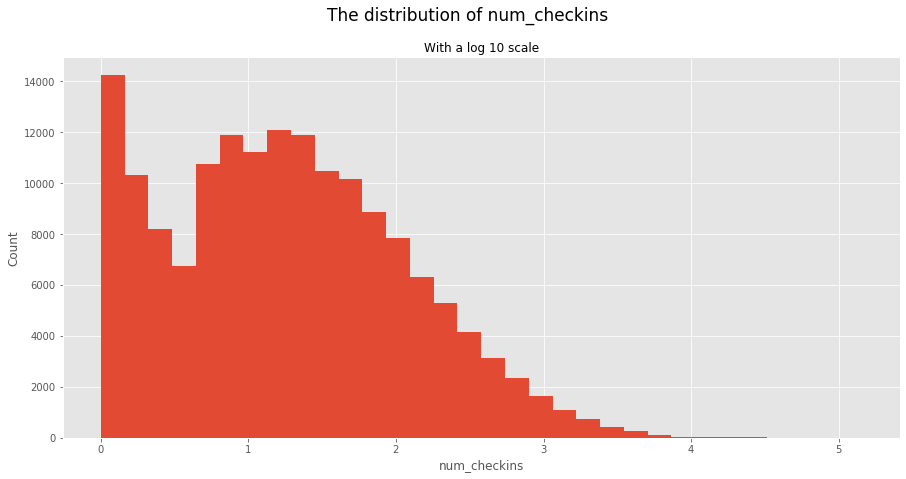

In [58]:
df_business_checkins["num_checkins"].apply(lambda x : np.log10(x)).hist(bins=32)
plt.suptitle("The distribution of num_checkins", fontsize=17)
plt.title("With a log 10 scale", fontsize=12)
lbl = plt.ylabel("Count"), plt.xlabel("num_checkins")

From the graph above, we can see that the graph resembles a bimodal distribution. The two modes occur at $10^0$ and $10^1$. We can also see that after $10^2$, the number of listings start to decrease rapidly. 

From the graph above, I think it is reasonable to drop listings that have over 1000 checkins, as without doing so future graphs will be heavily skewed. We will continue the analysis with the modifed dataframe. 

In [59]:
df_business_checkins = df_business_checkins[df_business_checkins["num_checkins"] <= 1000]

print("There are {} datapoints remaining.".format(df_business_checkins.shape[0]))

There are 157158 datapoints remaining.


We'll first investigate the correlation between number of reviews and ratings. We'll use a scatterplot to determine if there is any visual relationship between the two variables. 

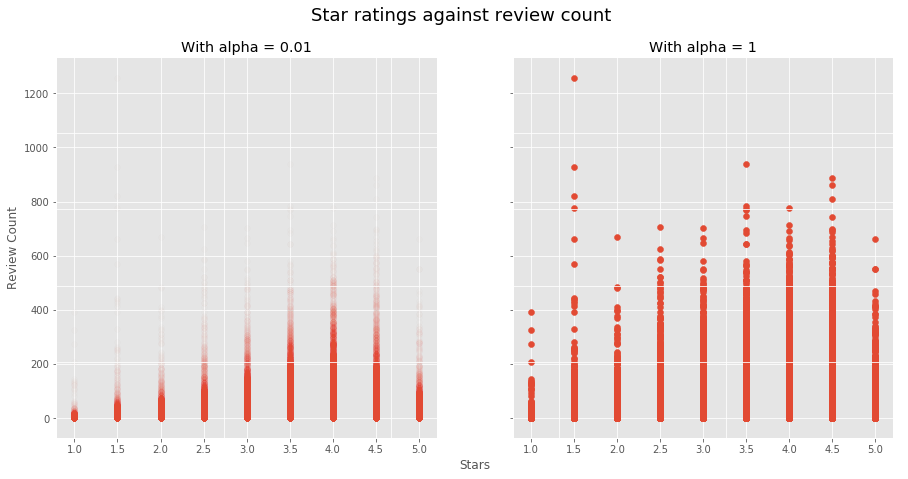

In [60]:
fig, ax = plt.subplots(1, 2, sharey= True)


ax[0].scatter(df_business_checkins["stars"], df_business_checkins["review_count"], 
             alpha = 0.01)

ax[1].scatter(df_business_checkins["stars"], df_business_checkins["review_count"])

ax[0].set_title("With alpha = 0.01")
ax[1].set_title("With alpha = 1")

ax[0].set_ylabel("Review Count")
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor="none", top=False, bottom=False, left=False, right=False)
plt.xlabel("Stars")
tit = fig.suptitle("Star ratings against review count", fontsize=18)

From the left graph above, we can see that listings with a rating of 4 has the highest number of review counts overall, as the cutoff when review counts starts to fade is the highest. However, high review counts do not mean that they get a perfect 5 rating. 

The distribution of the ratings and the plot above look similar, so there might be a confounding variable in play. 

We can take a look at the outliers that we can observe in the right graph. First, there is a point with 1,200 reviews yet a rating of only 1.5, and there is a listing with more than 600 reviews but still maintains a 5.0 rating. 

In [61]:
pd.DataFrame(df_business_checkins.loc[df_business_checkins["review_count"].idxmax()]).T[
    checkin_simple
]

name       city state stars review_count  \
e0CTLPxTnFEQSqQ1FJUqog  Fox Rent A Car  Las Vegas    NV   1.5         1258   

                       num_checkins  
e0CTLPxTnFEQSqQ1FJUqog          721

In [62]:
b_id = df_business_checkins[df_business_checkins["stars"] == 5]["review_count"].idxmax()
pd.DataFrame(df_business_checkins.loc[b_id]).T[
    checkin_simple
]

name       city state  \
Kp4i7on7rxFRkWceKfL2Ig  Paranormal - Mind Reading Magic Show  Las Vegas    NV   

                       stars review_count num_checkins  
Kp4i7on7rxFRkWceKfL2Ig     5          662          211

It's interesting to discover that the outlier we see with a low rating and such a high review count is in fact a rental car service, and that the outlier with a high rating despite the high review count is a magic show. 

We can also find the pearson correlation coefficient to see if there is any positive correlation. 

In [63]:
def print_correlation(data1, data2):
    """
    Prints the correlation between the two datasets. 
    """
    r_value = stats.pearsonr(data1, data2)[0]
    print("The correlation coefficient is: {:.3f}".format(r_value))
    
print_correlation(df_business_checkins["stars"], df_business_checkins["review_count"])

The correlation coefficient is: 0.060


The correlation coefficient says that the correlation is very tiny, almost negligible. This does not mean that there is no relationship between the two however, as we can clearly see from the graph. 

Next, we can plot the relationship between ratings and number of checkins. 

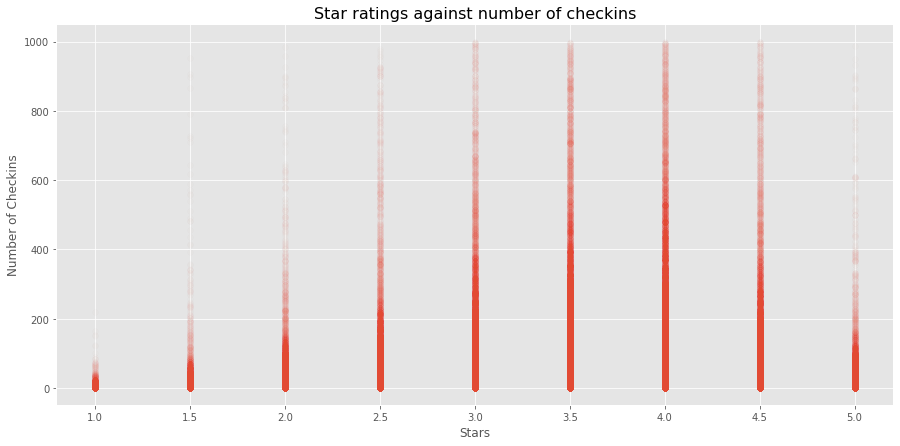

In [736]:
plt.scatter(df_business_checkins["stars"], df_business_checkins["num_checkins"], alpha = 0.01)

plt.title("Star ratings against number of checkins", fontsize=16)
lbl = plt.xlabel("Stars"), plt.ylabel("Number of Checkins")

From first glance, it seems that listings with high ratings have a higher number of checkins overall. However, this might be due to review count being a confounding variable. To confirm this, we can check the relationship between checkins and review count. 

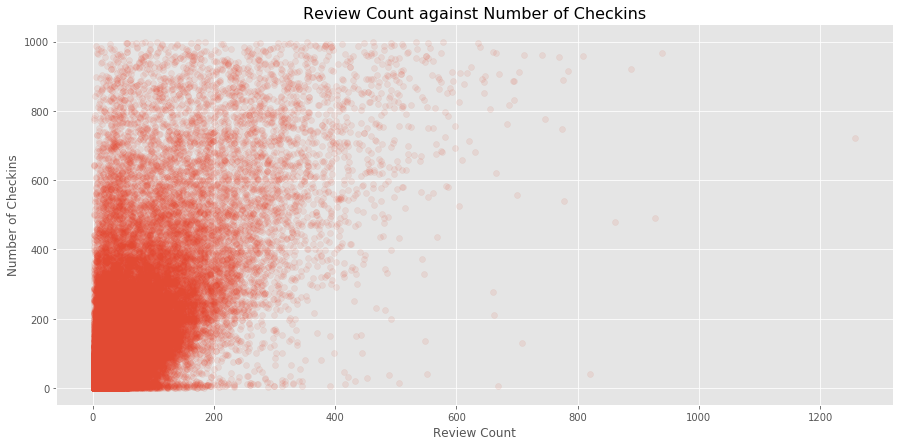

In [737]:
plt.scatter(df_business_checkins["review_count"], df_business_checkins["num_checkins"], alpha=0.1)
plt.title("Review Count against Number of Checkins", fontsize=16)
lbl = plt.ylabel("Number of Checkins"), plt.xlabel("Review Count")

We can see a positive correlation between the two. As the number of reviews increases, the number of checkins seem to increase as well.

In [66]:
print_correlation(df_business_checkins["review_count"], df_business_checkins["num_checkins"])

The correlation coefficient is: 0.721


The correlation coefficient is very high, so we can confidently say that there is a positive correlation between number of checkins and the number of reviews. 

Therefore, we cannot say that the ratings directly lead to more sales, assuming that our initial assumption that check ins are correlated to sales is correct. Thus, no conclusion can be made on the initial claim with our dataset. 

## Businesses in the GTA

Now we will focus specifically on businesses that are located in the Greater Toronto Area. Based on the map that we have plotted previously, we can see that businesses listed in "Ontario" are all in the GTA. Thus, we can simply select datapoints that have the state listed as "ON". 

Alternatively, if this analysis was performed on a larger dataset that also included Ottawa / other major cities in Ontario, we can select businesses that are within a certain range of the center of Toronto. However, this adds unnecessary computation time, and thus we will stick with the solution listed above. 

In [67]:
df_GTA = df_business_cut[df_business_cut["state"] == "ON"].copy()
print("There are {} datapoints in this dataframe.".format(df_GTA.shape[0]))

There are 33228 datapoints in this dataframe.


**Categories** 

We can compare the different categories for businesses listed in the GTA, and compare it with the categories of the whole dataset. Firstly, we can find the top 5 unique category combinations. 

In [68]:
df_GTA["categories_set"].value_counts().head(5)

{Coffee & Tea, Food}            581
{Chinese, Restaurants}          542
{Hair Salons, Beauty & Spas}    465
{Restaurants, Pizza}            375
{Nail Salons, Beauty & Spas}    312
Name: categories_set, dtype: int64

Surprisingly, chinese restaurants show up as one of the most popular category combinations. This can be due to the greater racial diversity that Toronto offers, as well as the larger number of chinese immigrants. 

We also see that one of the most popular category combinations is "Food" and "Coffee & Tea". This might have two different implications: 

1) Canadians drink a large number of coffee, and thus there is a larger demand for cafes. [This article](https://www.cbc.ca/news/business/canada-coffee-tim-hortons-1.3745971) supports this argument, however no credible sources were found as there were no links and attempts to find the original EuroMonitor article failed. [Other sources](https://weaverscoffee.com/blogs/blog/the-worlds-top-coffee-consuming-nations-and-how-they-take-their-cup) list Canada as one of the top 10 coffee drinkers, however. 

2) A larger number of popular cafe chains are listed in Yelp in GTA than in other cities (most likely due to the prevalence of Tim Hortons), and thus inflates the number of "Food" and "Coffee & Tea" listings. 

We can also find the frequency of each individual category in the GTA. 

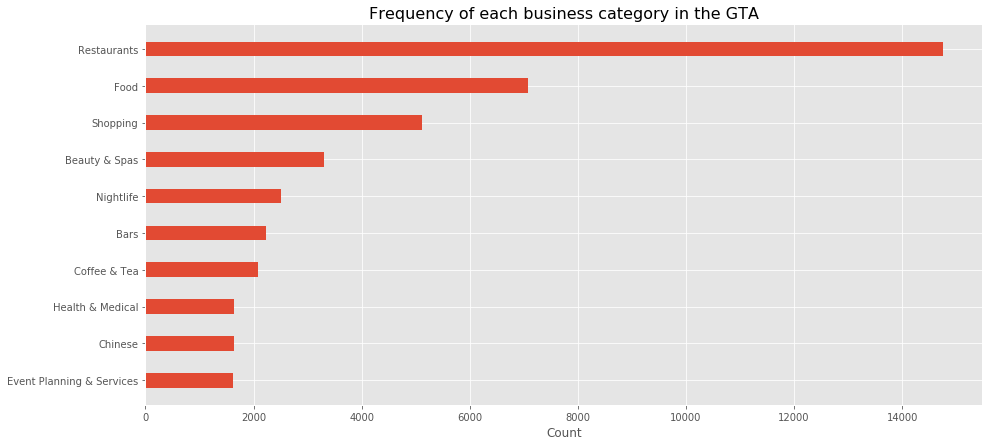

In [738]:
# categories_GTA = []

# for cat in categories:
#     n = (df_GTA["categories_set"].apply(lambda x : cat in x)).sum()
#     categories_GTA.append((n, cat))
    
categories_GTA = [(get_num_cat(df_GTA, cat),cat) for cat in categories]
categories_GTA.sort(reverse=True, key=lambda x: x[0])

NUM_TO_SHOW = 10

y_pos = [2*i for i in range(10)][::-1]

plt.barh(y_pos, [x[0] for x in categories_GTA[:NUM_TO_SHOW]])

ticks = plt.yticks(y_pos, [x[1] for x in categories_GTA[:NUM_TO_SHOW]])

plt.title("Frequency of each business category in the GTA", fontsize=16)
lbl = plt.xlabel("Count")

We don't see much difference in the distribution compared to the entire dataset, as restaurants, food and shopping still make up a large proportion. It is interesting to note that there are shopping is considerably less than food in the GTA dataset, while in the original dataset shopping and food are roughly equal. 

We can also compare the different restaurant types in the GTA with the complete dataset. 

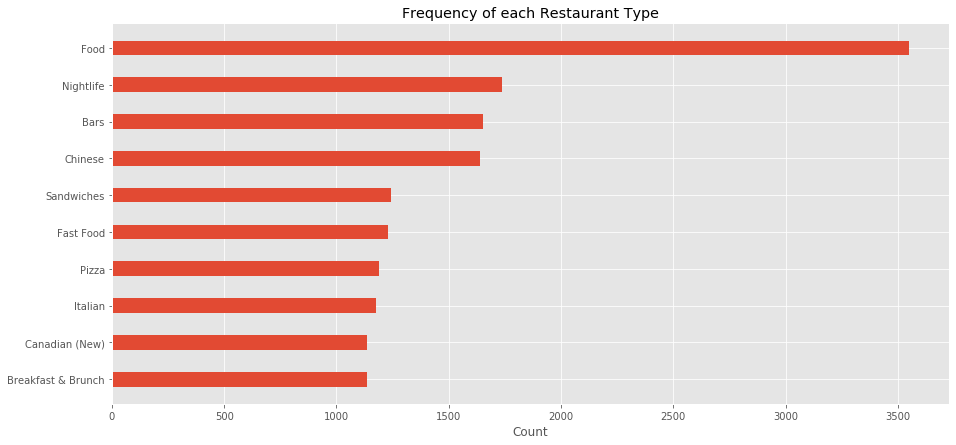

In [739]:
restaurant_filter = df_GTA["categories_set"].apply(lambda x : "Restaurants" in x)
df_GTA_rest = df_GTA[restaurant_filter]
# restaurant_cuisines = []
# for cat in categories:
#     n = df_GTA_rest["categories_set"].apply(lambda x: cat in x).sum()
#     restaurant_cuisines.append((n, cat))

restaurant_cuisines = [(get_num_cat(df_GTA_rest, cat), cat) for cat in categories]
restaurant_cuisines.sort(reverse=True, key = lambda x: x[0])
restaurant_cuisines = restaurant_cuisines[1:]


plt.barh(y_pos, [x[0] for x in restaurant_cuisines[:NUM_TO_SHOW]])

ticks = plt.yticks(y_pos, [x[1] for x in restaurant_cuisines[:NUM_TO_SHOW]])

plt.title("Frequency of each Restaurant Type")
lbl = plt.xlabel("Count")

Food, Nightlife and Bars are still the top 3 in both the GTA and the global dataset. Chinese food is also very popular. Unsuprisingly, American cuisine drops and Canadian food rises into the top 10. It is still suprising to me how nightlife and bars are some of the most popular restaurant types. 

**Canadian Franchises** 
<!-- 
1) tim hortons
2) second cup
3) pizza places - pizza pizza, pizza nova, little caesars, dominoes
4) popeyes
5) mcdonalds
6) burger king
7) starbucks
8) chipotle
9) KFC
10) wendys
11) dennys
 -->
 
We would like to investigate the most popular franchises in the city. Here are two strategies on how to tackle this problem: 

1) Count all the unique names in the GTA dataset, and select the top 5

2) Create a list of franchises that we hypothesize are the most popular, and count the number of occurences of each. 

The second strategy was thought up because of a problem we encountered earlier with McDonalds. It would be easier to think of the common franchises and use a regex to search for them to get an accurate count, since the first strategy would count "McDonald's" and "McDonalds" as two seperate entities. 

Ultimately, I decided to do some clean up of the franchise names, and then perform the first strategy. This would require a list of franchises that might have alternate spellings. To do this, I surveyed some friends for what they think might be popular franchises, and came up with the following that might have different spellings. 

* Tim Horton's / Tim Hortons
* KFC / Kentucky Fried Chicken
* McDonald's / McDonalds
* Wendys / Wendy's 
* Denny's / Dennys
* Popeye's / Popeyes / Popeyes Louisiana Kitchen
 
We will use regex to find occurences of these alternate variations and convert them into a single name. We will also convert all the names to be lower case to avoid any capitalization issues.

In [71]:
df_GTA_fran = df_GTA.copy()

df_GTA_fran["name"] = df_GTA_fran["name"].replace(regex={
    "Mc[D|d]onald'?s" : "McDonald's", 
    "Wendy'?s" : "Wendy's",
    "Kentucky Fried Chcken" : "KFC", 
    "Tim Horton'?s" : "Tim Horton's", 
    "Popeye'?s (Louisiana Kitchen)?" : "Popeye's",
    "Denny'?s" : "Denny's",
    "Shopper'?s" : "Shopper's",
    "Swiss Chalet.*" : "Swiss Chalet"
})

df_GTA_fran["name"] = df_GTA_fran["name"].apply(lambda x : x.lower())

In [72]:
pd.DataFrame(df_GTA_fran["name"].value_counts().head(10)).rename(columns={"name" : "Count"})

Count
tim horton's           288
starbucks              262
mcdonald's             156
shopper's drug mart    104
pizza pizza             95
subway                  87
swiss chalet            80
popeye's                70
goodlife fitness        70
second cup              63

From the table above, we can see that Tim Horton's is the most popular franchise in the GTA, followed closely by starbucks. A few surprises lie in the data: The inclusion of Swiss Chalet rotisserie & grill, as well as the exclusion of popular american fast food chains such as KFC and burger king. 

After interviewing a native Toronto friend, it appears that Swiss Chalet is indeed a popular diner and rotisserie chicken restaurant, well known for their sauce. After some investigation in the dataset, it appears that some locations drop the "rotisserie & grill" from the name. However, after fixing this mistake, there was no difference in the rankings. 

It will be interesting to investigate if this franchise has branched out or not. 

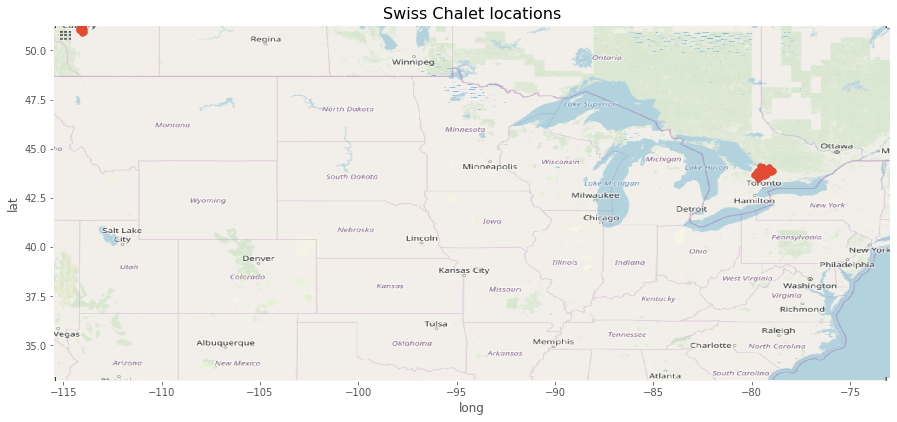

In [740]:
df_swiss = df_business_cut[df_business_cut["name"].str.match("Swiss Chalet")]


plt.scatter(df_swiss["longitude"], df_swiss["latitude"], alpha=1)
plt.xlim(boundaries[0], boundaries[1])
plt.ylim(boundaries[2], boundaries[3])
plt.xlabel("long")
plt.ylabel("lat")

map_ = plt.imread("./images/business_map_all.png")
im = plt.imshow(map_, zorder=0, extent=boundaries, aspect="equal")
tit = plt.title("Swiss Chalet locations", fontsize=16)
plt.grid(linestyle="")

We can see that Swiss Chalet is only located in the Canadian cities of the dataset, with the only locations being the GTA and in Alberta, near Calgary. This explains the lack of global popularity. 

Another interesting datapoint is Shopper's drug mart. It has [1,300 stores](https://en.wikipedia.org/wiki/Shoppers_Drug_Mart) open, which is a surprisingly large number. We can see how it's competitor - Rexall - compares. It is interesting to note that Rexall has multiple alternative names. We used a regex search to find all possible Rexalls.


In [74]:
pd.DataFrame.from_dict(
    {"Rexall" : df_GTA_fran[df_GTA_fran["name"].str.match("rexall")].shape[0]}, 
    orient="index").rename(columns={0:"Count"})

Count
Rexall     19

That is a surprisingly small number of Rexalls. Considering that a [large american company](https://www.theglobeandmail.com/report-on-business/mckesson-to-acquire-rexall-drugstore-chain-in-3-billion-deal/article28994105/) acquired Rexall in 2016, this might soon change, and we might see more Rexalls in the future. 

**Location and Reviews**

Next, we would like to investigate the relationship between locations and reviews. Below, we have mapped the location of all the businesses in the dataset. 


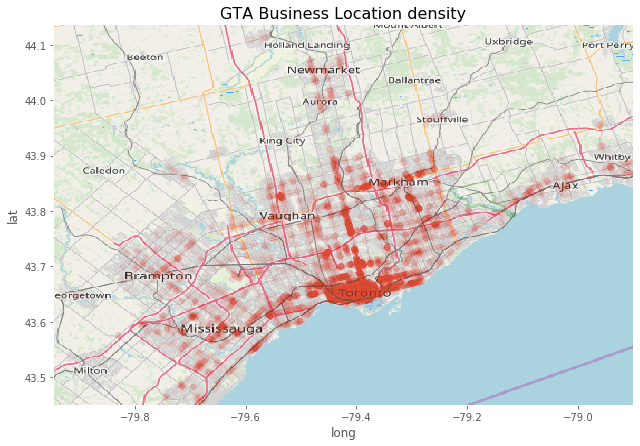

In [741]:
boundaries_GTA = (df_GTA["longitude"].min(), df_GTA["longitude"].max(), 
             df_GTA["latitude"].min(), df_GTA["latitude"].max())

plt.scatter(df_GTA["longitude"], df_GTA["latitude"], alpha=0.01)
plt.xlim(boundaries_GTA[0], boundaries_GTA[1])
plt.ylim(boundaries_GTA[2], boundaries_GTA[3])
plt.xlabel("long")
plt.ylabel("lat")

map_ = plt.imread("./images/map-3.png")
im = plt.imshow(map_, zorder=0, extent=boundaries_GTA, aspect="equal")
tit = plt.title("GTA Business Location density", fontsize=16)
plt.grid(linestyle="")

As we can see from the map above, most of the businesses are located in downtown. There is also a long strip of businesses, which upon further investigation is Yonge Street. 

We can map star ratings to hue, and plot it again with a higher opacity. Warmer colors indicate a higher star rating, and cooler colors indicate a lower star rating. 

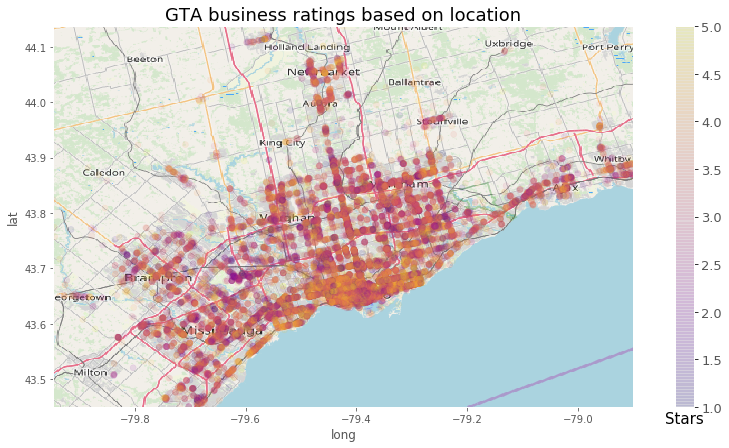

In [76]:
plt.scatter(df_GTA["longitude"], df_GTA["latitude"], alpha=0.1, c=df_GTA["stars"],cmap="plasma")
plt.xlim(boundaries_GTA[0], boundaries_GTA[1])
plt.ylim(boundaries_GTA[2], boundaries_GTA[3])
plt.xlabel("long")
plt.ylabel("lat")
cbar = plt.colorbar()

cbar.ax.set_xlabel("Stars", fontsize="15", color="black")
cbar.ax.tick_params("y", labelsize=13, color="black")
map_ = plt.imread("./images/map-3.png")
im = plt.imshow(map_, zorder=0, extent=boundaries_GTA, aspect="equal")
tit = plt.title("GTA business ratings based on location", fontsize=18)
plt.grid(linestyle="")

From the graph above, we can see that listings in the downtown area have a higher star rating than those outside downtown. Areas near the coastline also seem to have higher star ratings. We can do the same plotting idea with review counts. However, since review counts have a greater range compared to star ratings, we will take the natural log of review counts.  

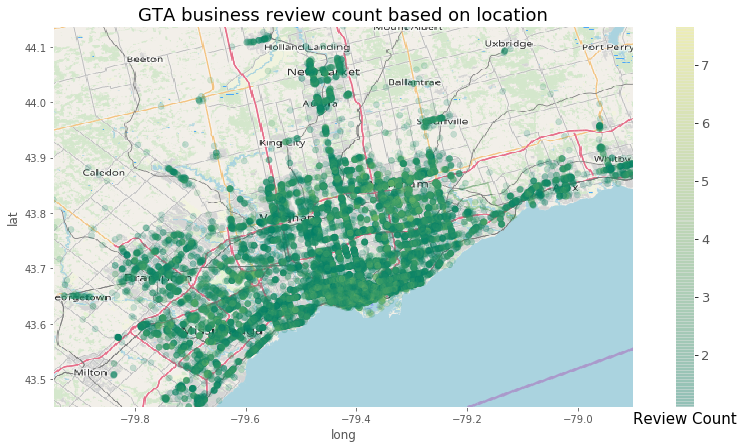

In [77]:
plt.scatter(df_GTA["longitude"], df_GTA["latitude"], alpha=0.2, c=
            df_GTA["review_count"].apply(lambda x : np.log(x)),cmap="summer")
plt.xlim(boundaries_GTA[0], boundaries_GTA[1])
plt.ylim(boundaries_GTA[2], boundaries_GTA[3])
plt.xlabel("long")
plt.ylabel("lat")
cbar = plt.colorbar()

cbar.ax.set_xlabel("Review Count", fontsize="15", color="black")
cbar.ax.tick_params("y", labelsize=13, color="black")
map_ = plt.imread("./images/map-3.png")
im = plt.imshow(map_, zorder=0, extent=boundaries_GTA, aspect="equal")
tit = plt.title("GTA business review count based on location", fontsize=18)
plt.grid(linestyle="")

From the map above, we can see that the number of reviews generally do not change too much compared to ratings. Downtown areas do have higher review counts, and a small area near markham also has more review counts. Otherwise, there are generally 4-10 reviews for each business in yelp for the GTA. 

Therefore, we can conclude that there is a relationship between location and ratings, and a smaller relationship between location and review counts. However, this doesn't mean that location implies that ratings will increase - it may simply mean that better businesses are more likely to be located in populous areas than sparse areas.

It will be interesting to plot the stars of all the Tim Horton's locations to see if Tim's is better in downtown. 

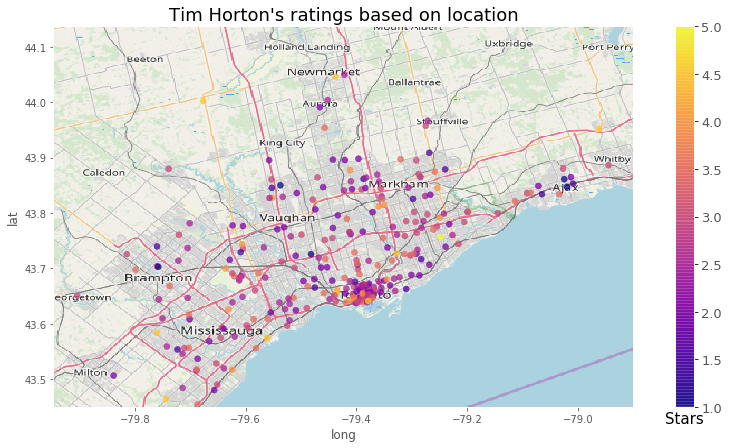

In [78]:
df_tims = df_GTA_fran[df_GTA_fran["name"] == "tim horton's"]

plt.scatter(df_tims["longitude"], df_tims["latitude"], alpha=0.75, c=df_tims["stars"],cmap="plasma")
plt.xlim(boundaries_GTA[0], boundaries_GTA[1])
plt.ylim(boundaries_GTA[2], boundaries_GTA[3])
plt.xlabel("long")
plt.ylabel("lat")
cbar = plt.colorbar()

cbar.ax.set_xlabel("Stars", fontsize="15", color="black")
cbar.ax.tick_params("y", labelsize=13, color="black")
map_ = plt.imread("./images/map-3.png")
im = plt.imshow(map_, zorder=0, extent=boundaries_GTA, aspect="equal")
tit = plt.title("Tim Horton's ratings based on location", fontsize=18)
plt.grid(linestyle="")

It does seem like downtown Tim Horton's are generally rated slightly better than those outside downtown. However, it appears that the highest rated Tim's are isolated from most other Tim Hortons.

**Tim Hortons and Starbucks** 

We would like to investigate the claim that for every Tim Hortons, there is Starbucks nearby. First, we have to define what nearby is. The average human walks 1.4 m/s (from [wikipedia](https://en.wikipedia.org/wiki/Walking)), and we'll define nearby as being around 5 minutes away. This works out to be about 420 meters. For simplicity, we will use 400m.  Therefore, we can define nearby as being within a 400m radius. 

We will calculate distance with the haversine method. This means that the distance does not reflect real world walking distances (as in the real world, obstacles exist and we cannot walk directly in a straight line to destinations), however for the purposes of this analysis that it is accurate enough. 

We will iterate over every Tim Hortons, and for every Tim Hortons we will calculate the distance of every starbucks to it. Although this process isn't efficient, since our input size is rather small (about 250 for both franchises), we will not worry too much about efficiency. 

Before the analysis however, we can plot all the locations of Tim Hortons and Starbucks onto a map. 

In [79]:
df_GTA_tims = df_GTA_fran[df_GTA_fran["name"] == "tim horton's"].copy()
df_GTA_tims["lat_lon"] = [(df_GTA_tims.iloc[i]["latitude"],df_GTA_tims.iloc[i]["longitude"]) \
                          for i in range(df_GTA_tims.shape[0])]

df_GTA_starbucks = df_GTA_fran[df_GTA_fran["name"] == "starbucks"].copy()
df_GTA_starbucks["lat_lon"] = [(df_GTA_starbucks.iloc[i]["latitude"], df_GTA_starbucks.iloc[i]["longitude"]) \
                              for i in range(df_GTA_starbucks.shape[0])]


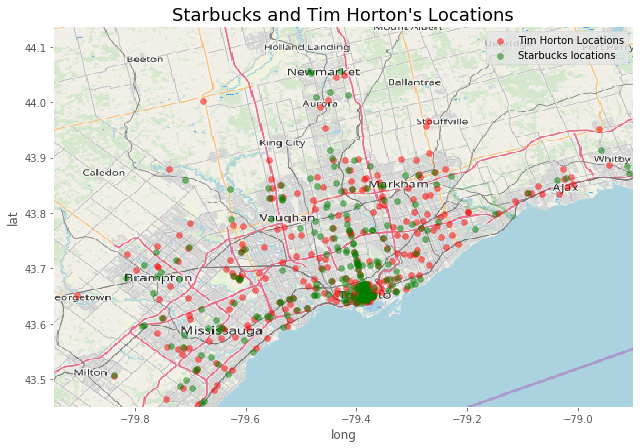

In [100]:
plt.scatter(df_GTA_tims["longitude"], df_GTA_tims["latitude"], alpha=0.5, color="red",
           label="Tim Horton Locations")

plt.scatter(df_GTA_starbucks["longitude"], df_GTA_starbucks["latitude"], alpha=0.5, color="green", 
            label="Starbucks locations")

plt.xlim(boundaries_GTA[0], boundaries_GTA[1])
plt.ylim(boundaries_GTA[2], boundaries_GTA[3])
plt.xlabel("long")
plt.ylabel("lat")

plt.legend()

map_ = plt.imread("./images/map-3.png")
im = plt.imshow(map_, zorder=0, extent=boundaries_GTA, aspect="equal")
tit = plt.title("Starbucks and Tim Horton's Locations", fontsize=18)
plt.grid(linestyle="")

In [80]:
# The code below is equivalent to:

# min_distances = []
# for tim in df_GTA_times["lat_lon"]:
#     distance = []
#     for star in df_GTA_starbucks["lat_lon"]:
#         distance.append(haversine.haversine(time, star, "m"))
#     min_distances.append(min(distance))

distances = [[haversine.haversine(tim, star, "m") for star in df_GTA_starbucks["lat_lon"]] \
            for tim in df_GTA_tims["lat_lon"]]

df_GTA_tims["d_nearest_starbucks"] = [min(dists) for dists in distances]

In [81]:
pd.DataFrame(df_GTA_tims["d_nearest_starbucks"].describe())

d_nearest_starbucks
count           288.000000
mean           1199.933423
std            1600.785784
min               0.000000
25%             226.620824
50%             780.117887
75%            1674.302913
max           16164.783251

In [82]:
isolated_tims = df_GTA_tims.loc[df_GTA_tims["d_nearest_starbucks"].idxmax()]
star_tims = df_GTA_tims[df_GTA_tims["d_nearest_starbucks"] == 0]

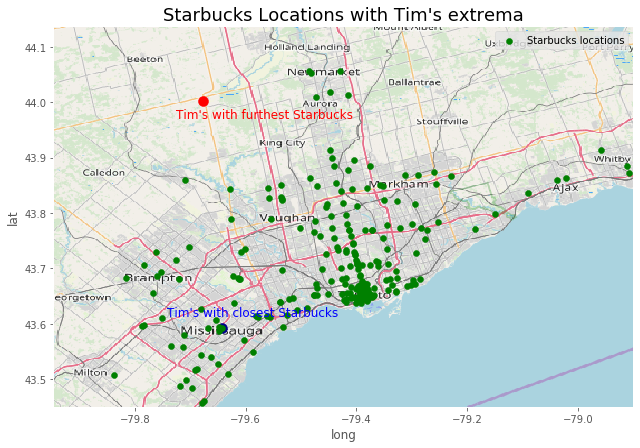

In [83]:
plt.scatter(isolated_tims["longitude"], isolated_tims["latitude"], alpha=1, color="red", s=100)
plt.scatter(star_tims["longitude"], star_tims["latitude"], alpha=1, color="darkblue", s=100)

plt.scatter(df_GTA_starbucks["longitude"], df_GTA_starbucks["latitude"], alpha =1, color="green", 
            label="Starbucks locations")

plt.xlim(boundaries_GTA[0], boundaries_GTA[1])
plt.ylim(boundaries_GTA[2], boundaries_GTA[3])
plt.xlabel("long")
plt.ylabel("lat")

plt.text(isolated_tims["longitude"]-0.05, isolated_tims["latitude"]-0.03, "Tim's with furthest Starbucks", 
         color="red", fontsize=12)
plt.text(star_tims["longitude"]-0.1, star_tims["latitude"]+0.02, "Tim's with closest Starbucks", 
         color="blue", fontsize=12)
plt.legend()

map_ = plt.imread("./images/map-3.png")
im = plt.imshow(map_, zorder=0, extent=boundaries_GTA, aspect="equal")
tit = plt.title("Starbucks Locations with Tim's extrema", fontsize=18)
plt.grid(linestyle="")

We can also see the exact addresses of the two Tim's. 

In [84]:
print("The Tim's with the furthest Starbucks is at {}, {}. It has a rating of {}.".format(
isolated_tims["address"], isolated_tims["city"], isolated_tims["stars"]))

print("\n")

print("The Tim's with the closest Starbucks is at {}, {}. It has a rating of {}.".format(
    star_tims["address"].iloc[0], star_tims["city"].iloc[0], star_tims["stars"].iloc[0]))

The Tim's with the furthest Starbucks is at 17250 Highway 27, Schomberg. It has a rating of 4.5.


The Tim's with the closest Starbucks is at 100 City Centre Drive, Mississauga. It has a rating of 3.0.


Let's take a look at the distribution of the distances to the nearest Starbucks. 

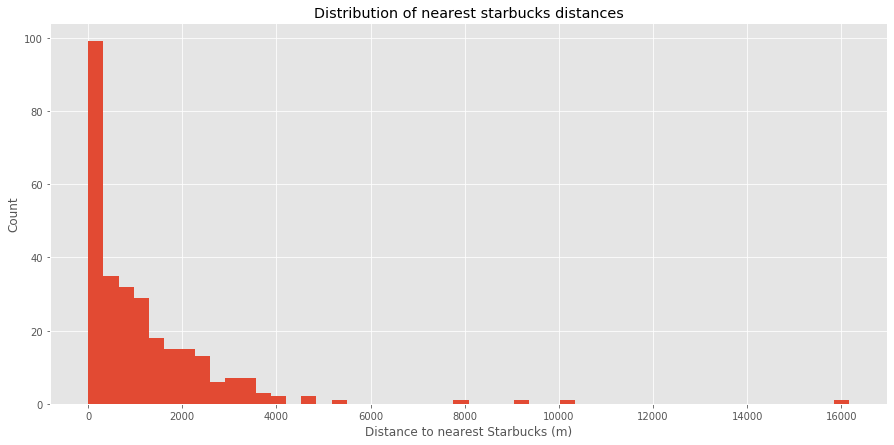

In [85]:
df_GTA_tims["d_nearest_starbucks"].hist(bins=50)
plt.title("Distribution of nearest starbucks distances")
lbl = plt.ylabel("Count"), plt.xlabel("Distance to nearest Starbucks (m)")

From the graph above, we can see most Starbucks are less than 2km away from a Tim horton's. It also resembles an exponential distribution. The bin that includes 0 - 300 is very large, so let's also take a look at the distribution of nearest starbucks distances for Tim's that are at least within 2km of the nearest starbucks. 

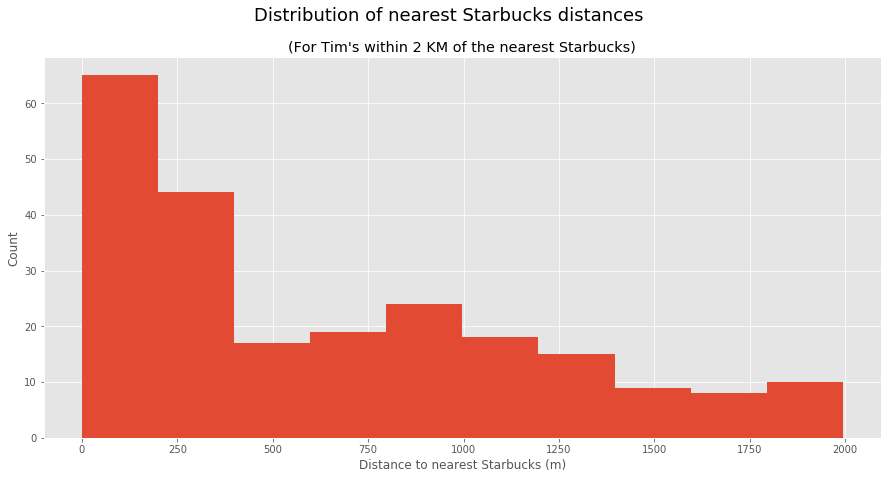

In [86]:
df_GTA_tims[df_GTA_tims["d_nearest_starbucks"] <= 2000]["d_nearest_starbucks"].hist()
plt.suptitle("Distribution of nearest Starbucks distances", fontsize=18)
plt.title("(For Tim's within 2 KM of the nearest Starbucks)")
lbl = plt.ylabel("Count"), plt.xlabel("Distance to nearest Starbucks (m)")

The graph above shows that the distribution can be seen as slightly bimodal: With a large proportion within 250m of the nearest tims, and another mode at around 750-1000 m of the nearest starbucks. 

We can calculate what percentage of Tim's satisfy our definition of having a starbucks nearby, and map where they are:

In [87]:
df_GTA_tims_400 = df_GTA_tims[df_GTA_tims["d_nearest_starbucks"] <= 400]

print("{:.2f}% of Tim's are have a Starbucks within a 400m radius.".format(
df_GTA_tims_400.shape[0] * 100 / df_GTA_tims.shape[0]))



37.85% of Tim's are have a Starbucks within a 400m radius.


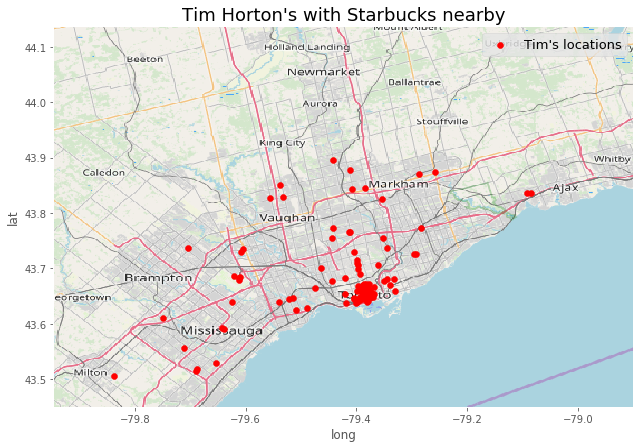

In [88]:
plt.scatter(df_GTA_tims_400["longitude"], df_GTA_tims_400["latitude"], alpha=1, color="Red", 
            label="Tim's locations")


plt.xlim(boundaries_GTA[0], boundaries_GTA[1])
plt.ylim(boundaries_GTA[2], boundaries_GTA[3])
plt.xlabel("long")
plt.ylabel("lat")

plt.legend(fontsize=13)

map_ = plt.imread("./images/map-3.png")
im = plt.imshow(map_, zorder=0, extent=boundaries_GTA, aspect="equal")
tit = plt.title("Tim Horton's with Starbucks nearby", fontsize=18)
plt.grid(linestyle="")

We can see that a large majority of Tim's with a Starbucks nearby is located downtown. Therefore, we can say that in Downtown, there is a Tim's with a Starbucks nearby. Outside downtown toronto however, it is less clear, and it varies on the definition of nearby. For this analysis, we can say that outside downtown, the claim that there is Starbucks near any Tim's is generally untrue. 

## Reviews 

Now, let's take explore the **Reviews** and **Users** dataset. Both the datasets are very large (5GB and 2GB respectively), so loading the data into a dataframe will take a while. 

We can take a look at some of the summary statistics of these two datasets before we proceed any further. 

In [104]:
df_reviews = get_dataframe_from_json("./yelp_dataset/review.json")
df_users = get_dataframe_from_json("./yelp_dataset/user.json")

In [108]:
df_reviews.describe().round(3)

stars       useful        funny         cool
count  6685900.000  6685900.000  6685900.000  6685900.000
mean         3.716        1.354        0.483        0.579
std          1.464        3.700        2.379        2.359
min          1.000       -1.000        0.000       -1.000
25%          3.000        0.000        0.000        0.000
50%          4.000        0.000        0.000        0.000
75%          5.000        2.000        0.000        1.000
max          5.000     1241.000     1290.000      506.000

In [110]:
df_users.describe().round(3)[["review_count", "fans", "average_stars"]]

review_count         fans  average_stars
count   1637138.000  1637138.000    1637138.000
mean         22.288        1.466          3.681
std          76.922       15.683          1.151
min           0.000        0.000          1.000
25%           2.000        0.000          3.000
50%           5.000        0.000          3.890
75%          15.000        0.000          4.600
max       13278.000     9538.000          5.000

The first table shows the summary statistics for the reviews dataframe. We can see that this dataframe is exceedingly large (with 6.6 million datapoints). It's worth nothing that the min for "useful" and "cool" is -1. We might have to investigate this further if it becomes a problem. 

The second table shows the summary statistics for the users dataframe. The columns were limited to only review count, fans and average stars since there are many columns in this dataframe. Although this dataframe is not as large as the reviews dataframe, we can still see that it is still rather large, with 1.6 million datapoints. We can also see a small glimpse of a "power user", with a max review count of 13278. Let's investigate this user further. We will only show some select columns.  

In [115]:
pd.DataFrame(df_users.loc[df_users["review_count"].idxmax]).T[
    ["user_id", "name", "review_count", "yelping_since", "average_stars", "fans"]
]

user_id    name review_count        yelping_since  \
818915  8k3aO-mPeyhbR5HUucA5aA  Victor        13278  2007-12-08 14:56:45   

       average_stars  fans  
818915          3.28  1125

This user, going by the name [Victor G](https://www.yelp.com/user_details?userid=8k3aO-mPeyhbR5HUucA5aA), has been reviewing an average of about 3 places a day for 11 years. His work even captured the attention of some journalists, as seen [here](https://www.bizjournals.com/sanfrancisco/blog/2014/01/oakland-yelp-hits-record-with-1712.html).

For this analysis, we will only be using reviews that are contained within the GTA. We will create a new dataframe of reviews that contain business_ids that match those in our GTA dataframe. 

In [128]:
GTA_businesses = set(df_GTA["business_id"].unique())
GTA_filter = df_reviews["business_id"].apply(lambda x : x in GTA_businesses)
df_reviews_GTA = df_reviews[GTA_filter].copy()

In [131]:
print("There are {} reviews for businesses in the GTA.".format(df_reviews_GTA.shape[0]))

There are 781706 reviews for businesses in the GTA


Let's take a look at the descriptive statistics for this dataframe and compare it with the larger one to see if there are any differences. 

In [132]:
df_reviews_GTA.describe()

stars         useful          funny           cool
count  781706.000000  781706.000000  781706.000000  781706.000000
mean        3.537645       1.364508       0.435155       0.541380
std         1.348389       3.284027       1.694122       2.004137
min         1.000000       0.000000       0.000000       0.000000
25%         3.000000       0.000000       0.000000       0.000000
50%         4.000000       0.000000       0.000000       0.000000
75%         5.000000       2.000000       0.000000       1.000000
max         5.000000     280.000000     264.000000     177.000000

The two summary statistics seem to be mostly similar. The only noticable difference in the statistics are the max values, which are significantly less than the larger dataset. We also notice that there is no min of "-1", so we can safely ignore that for now. 

With the dataset ready, we can begin our analysis. We would like to investigate if there is a small number of users that are responsible for most reviews. We can first use value counts on the user_id column, and see the distribution of reviews. For the graph, we will take a sample of 200. We will assume that this is large enough number such that the distribution of the sample represents the distribution of the whole population. 


In [140]:
user_review_counts = df_reviews_GTA["user_id"].value_counts()

In [182]:
user_review_counts_small = user_review_counts.sample(200, random_state=42).sort_values(ascending=False)

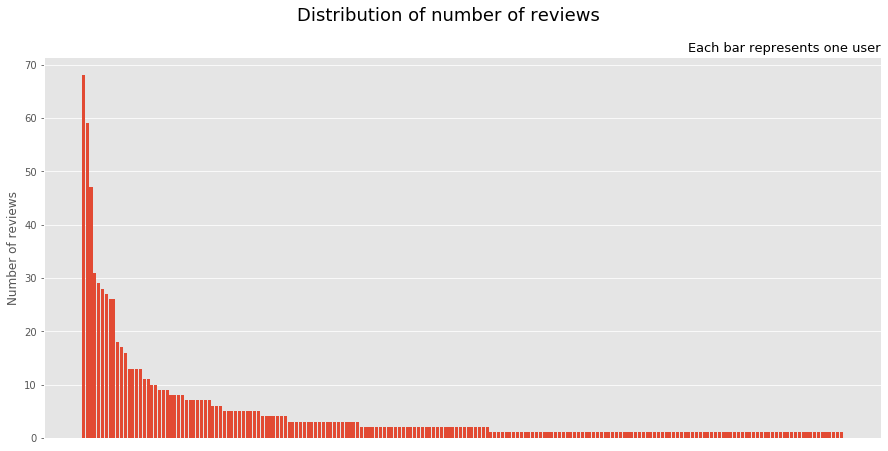

In [746]:
plt.bar(np.arange(200), user_review_counts_small.values)
plt.xticks([])
plt.ylabel("Number of reviews")
plt.suptitle("Distribution of number of reviews", fontsize=18)
tit= plt.title("Each bar represents one user", fontsize=13, loc="right")

As we can see from the graph above, the distribution roughly follows an exponential distribution. The actual distribution of the whole dataset might look more extreme, as there might be more "power users" that review a lot of places. We can look at the top 10 reviewers, and the number of reviews in the GTA they have. 

In [210]:
power_users = set(user_review_counts.head(10).index)
df_GTA_power_users = df_users[df_users["user_id"].apply(lambda x : x in power_users)].copy()
df_GTA_power_users.sort_values(by="user_id", inplace=True)
user_review_counts.head(10).sort_values()

In [213]:
df_GTA_power_users["reviews_in_GTA"] = user_review_counts.head(10).sort_index().values

In [218]:
columns_to_show = ["name", "review_count", "reviews_in_GTA", "fans"]

df_GTA_power_users.sort_values(by="reviews_in_GTA",
                              ascending=False)[columns_to_show]

name  review_count  reviews_in_GTA  fans
2202     Jennifer          6314            3934   715
2262      Laura C          1181             999   103
908        Evelyn          1274             993   478
31084   Stephanie          1310             980   184
3529         Kris          1356             917   563
122562        Deb           909             883    35
12750      Bernie          1108             873    57
70317       Teena          1239             821    34
24568        Owen          1595             798    29
13973       Elvis          1047             774    54

It's interesting to note that all the top 10 reviewers for the GTA do not solely review locations in the GTA, however a majority of their reviews are in the GTA. This might mean that these reviewers live inside the GTA, however during they continue reviewing businesses during trips. 

We might also investigate the following corollary: Does the distribution of review counts follow the [Pareto principle](https://en.wikipedia.org/wiki/Pareto_principle)? In other words, do 20% of users contribute to 80% of reviews? 

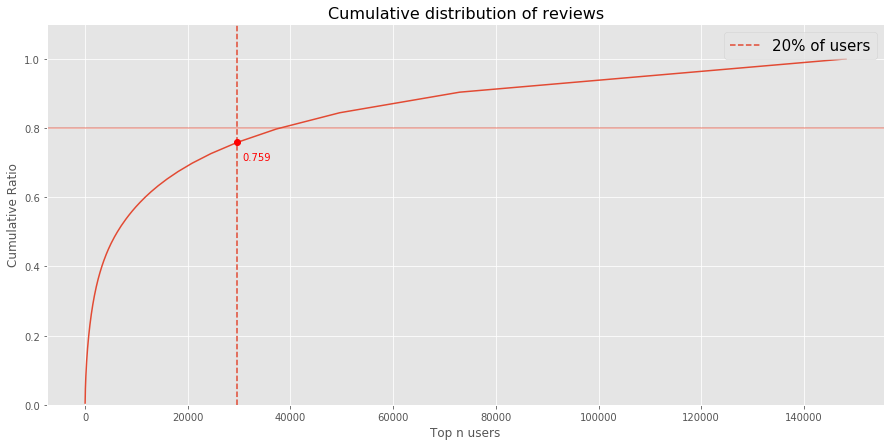

In [742]:
total_reviews = df_reviews_GTA.shape[0]
curr_count = 0

def add_to_curr(x):
    """
    Adds the review to the current count, and return the new cumulative ratio.
    """
    global curr_count
    curr_count += x
    return curr_count/total_reviews

num_20 = int(user_review_counts.shape[0] / 5)
y_values = [add_to_curr(x) for x in user_review_counts.values]

plt.plot(np.arange(user_review_counts.shape[0]), y_values)
plt.ylim(0, 1.1)
plt.axhline(y=0.8, alpha=0.5)
plt.axvline(x=num_20, ls='--', label="20% of users")
plt.legend(fontsize=15)

plt.ylabel("Cumulative Ratio")
plt.xlabel("Top n users")

plt.plot(num_20, y_values[num_20-1], 'ro')
plt.text(num_20 + 1000, y_values[num_20-1] - 0.05, "{:.3f}".format(y_values[num_20-1]), color="red")
tit = plt.title("Cumulative distribution of reviews", fontsize=16)

As we can see above, the 20% of users does not *exactly* contribute to 80% of the number of reviews, however it is still a large proportion, and close enough to 80%. We can therefore confidently say that a small group of users is responsible for the majority of reviews, and that the distribution of reviews follow the Pareto Principle. 

#### Tim Horton's and Starbucks Reviews

Let's go back to our two favorite coffee franchises. We are interested in the language used to review both the franchises, both in general and for users who reviewed both franchises. We will be using the ntlk package and it's Sentiment Intensity Analyzer to get the positivity or negativity of each review. I will be following the steps in [this](https://towardsdatascience.com/basic-binary-sentiment-analysis-using-nltk-c94ba17ae386) article as well as some of my own personal experience with NLTK to perform this step in the analysis. 

We will also be using the universal pos tag instead of the default pos tag to simplify this analysis.

Before all of that however, we have to create a new dataframe for reviews for starbucks and tim hortons. Let's take a look at some simple plots and summary statistics. 

In [309]:
tims_id = set(df_GTA_tims["business_id"].unique())
starbucks_id = set(df_GTA_starbucks["business_id"].unique())

df_reviews_s = df_reviews_GTA[df_reviews_GTA["business_id"].apply(
                lambda x : x in starbucks_id)].copy().reset_index(drop=True)
df_reviews_s["franchise"] = "starbucks"

df_reviews_t = df_reviews_GTA[df_reviews_GTA["business_id"].apply(
                lambda x : x in tims_id)].copy().reset_index(drop=True)
df_reviews_t["franchise"] = "tim hortons"

df_reviews_fran = pd.concat([df_reviews_s, df_reviews_t])
df_reviews_fran.reset_index(drop=True, inplace=True)

In [324]:
fran_stars = pd.DataFrame({"Starbucks Stars": df_reviews_s["stars"],
              "Tim Horton's Stars": df_reviews_t["stars"]})
fran_stars.describe()

Starbucks Stars  Tim Horton's Stars
count      2897.000000         1801.000000
mean          3.417328            2.735147
std           1.241887            1.345500
min           1.000000            1.000000
25%           3.000000            1.000000
50%           4.000000            3.000000
75%           4.000000            4.000000
max           5.000000            5.000000

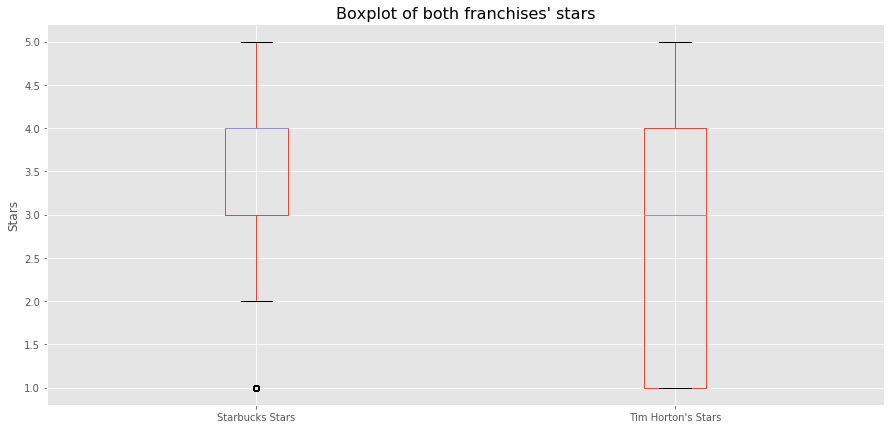

In [743]:
fran_stars.boxplot()
plt.ylabel("Stars")
tit = plt.title("Boxplot of both franchises' stars", fontsize=16)

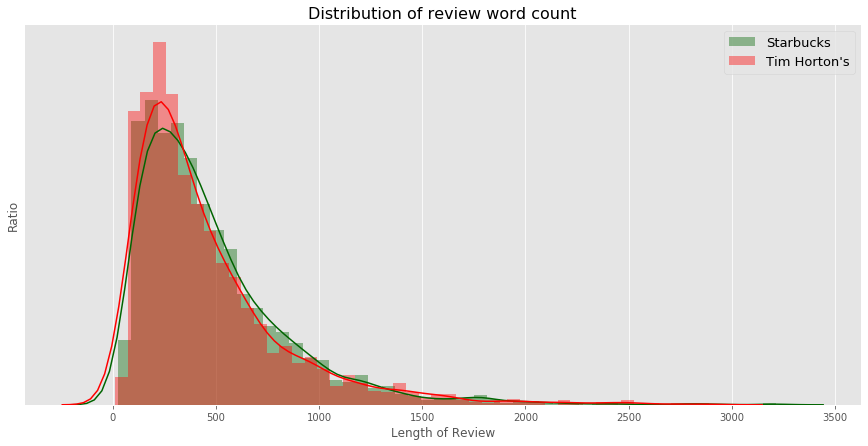

In [744]:
sns.distplot(df_reviews_s["text"].apply(lambda x : len(x)), color="darkgreen", label="Starbucks")
sns.distplot(df_reviews_t["text"].apply(lambda x : len(x)), color="red", label="Tim Horton's")

plt.ylabel("Ratio"), plt.xlabel("Length of Review")
plt.yticks([])
plt.legend(fontsize=13)

tit = plt.title("Distribution of review word count", fontsize=16)

We can see from the summary statistics that the reviews for starbucks are generally more positive than the reviews for tim horton's. 

I also thought that as Tim's reviews are less positive, there will be more people who complain in the reviews, leading to a higher word count average, however based on the plotted distribution above there doesn't seem to be any evidence to support my claim. Now, let's take a look at an example review for Tim Horton's, and strategize what we can do to analyze it. 

In [339]:
ran_review = df_reviews_fran[df_reviews_fran["franchise"] == "tim hortons"].sample(1, random_state = 270)

print("An example Tim Horton's review: \n")
print(ran_review.iloc[0]["text"])
print("\n")
print("This review had a {} star rating.".format(ran_review.iloc[0]["stars"]))

An example Tim Horton's review: 

This location is disastrous. The lines are confusing and it is hard to know which cashier is open. The wait is always long, even just for a coffee. The staff are nice and they are always in an ER mode. Either the location is severely understaffed, or there is something wrong with the work flow. Tim Horton's really needs to learn from MacDonald about modernization.


This review had a 2.0 star rating.


Following the article mentioned above, we should tokenize each review and remove stop words. From here, we can do several things. We can use postagging to identify the adjectives used to see what most people use to describe each franchise. We can also calculate the positivity/negativity of each review using the SIA. Furthermore, we can see how the star rating correlates with the polarity score of each review.

For this analysis, we will use the assumption that most people tend to spell-check their reviews before posting online. 

We will first find the most commonly used words to describe each location. We will use pos-tagging to identify all the adjectives used in reviews for both starbucks and tim horton's, and count the number of appearances each adjectives have. 

In [402]:
def remove_punctuation(x):
    """
    Removes all punctuation from the string x. 
    """
    return re.sub("[^\w\d\s]", "", x)

def get_adjectives(x):
    """
    Returns all the adjectives used in the string x. 
    """
    pos_tag = nltk.pos_tag(nltk.word_tokenize(remove_punctuation(x)), "universal")
    return [word[0] for word in pos_tag if word[1] == "ADJ"]


def get_all_adjectives(data):
    """
    Return a dictionary of all the adjectives used in data alongside the count of each adjective. 
    """
    dataframe_adjectives = {}

    for adjectives in data.apply(get_adjectives):
        for adjective in adjectives:
            if adjective not in dataframe_adjectives:
                dataframe_adjectives[adjective] = 0
            dataframe_adjectives[adjective] += 1
    
    return dataframe_adjectives


In [404]:
starbucks_adjectives = get_all_adjectives(df_reviews_s["text"])
tims_adjectives = get_all_adjectives(df_reviews_t["text"])

In [495]:
df_star_adj = pd.DataFrame.from_dict(starbucks_adjectives, orient="index", columns=["Count"]).sort_values(
    by="Count", ascending=False)
df_tims_adj = pd.DataFrame.from_dict(tims_adjectives, orient="index", columns=["Count"]).sort_values(
    by="Count", ascending=False)

df_star_adj = df_star_adj.reset_index().rename(columns={"index" : "Adjective"})
df_tims_adj = df_tims_adj.reset_index().rename(columns={"index" : "Adjective"})

total_star_adj = df_star_adj["Count"].sum()
total_tims_adj = df_tims_adj["Count"].sum()

df_star_adj["Ratio"] = df_star_adj["Count"].apply(lambda x : x/total_star_adj)
df_tims_adj["Ratio"] = df_tims_adj["Count"].apply(lambda x : x/total_tims_adj)

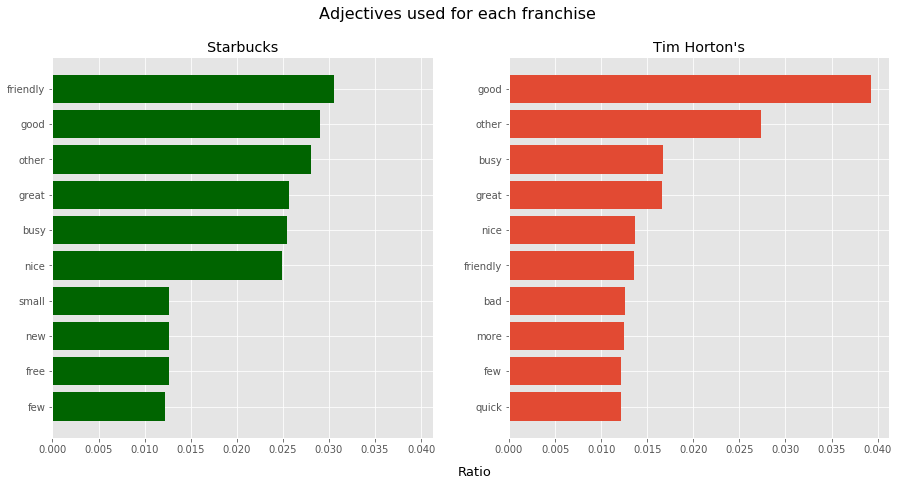

In [506]:
fig, ax = plt.subplots(1, 2, sharex=True)
ax[0].barh([x for x in range(10)][::-1], df_star_adj.head(10).sort_values(by="Ratio", ascending=False)["Ratio"],
          color="darkgreen")
ax[0].set_yticks([x for x in range(10)][::-1])
ax[0].set_yticklabels(df_star_adj.head(10).sort_values(by="Ratio", ascending=False)["Adjective"])
ax[0].set_title("Starbucks")

ax[1].barh([x for x in range(10)][::-1], df_tims_adj.head(10).sort_values(by="Ratio", ascending=False)["Ratio"])
ax[1].set_yticks([x for x in range(10)][::-1])
ax[1].set_yticklabels(df_tims_adj.head(10).sort_values(by="Ratio", ascending=False)["Adjective"])
ax[1].set_title("Tim Horton's")

fig.text(0.5, 0.05, "Ratio", fontsize=13)
tit = fig.suptitle("Adjectives used for each franchise", fontsize=16)

From the graph above, we can see that starbucks is more generally described as "friendly", as the appearance of both words differ greatly. We can also see that "bad" makes the top 10 adjectives used to describe Tim's, whereas it doesn't appear in Starbucks. Surprisingly, the ratio of usages of "good" is much higher in Tim's. 

There is a limitation to this graph, as it might have counted "not good" and "good" as the same since we tokenized each word. However, I don't believe that this affected the results too much. 

We can also look at all the frequency of negative adjectives. 

In [508]:
sia = SIA()

df_star_neg = df_star_adj[df_star_adj["Adjective"].apply(lambda x : sia.polarity_scores(x)["neg"]) > 0.5]
df_tims_neg = df_tims_adj[df_tims_adj["Adjective"].apply(lambda x : sia.polarity_scores(x)["neg"]) > 0.5]

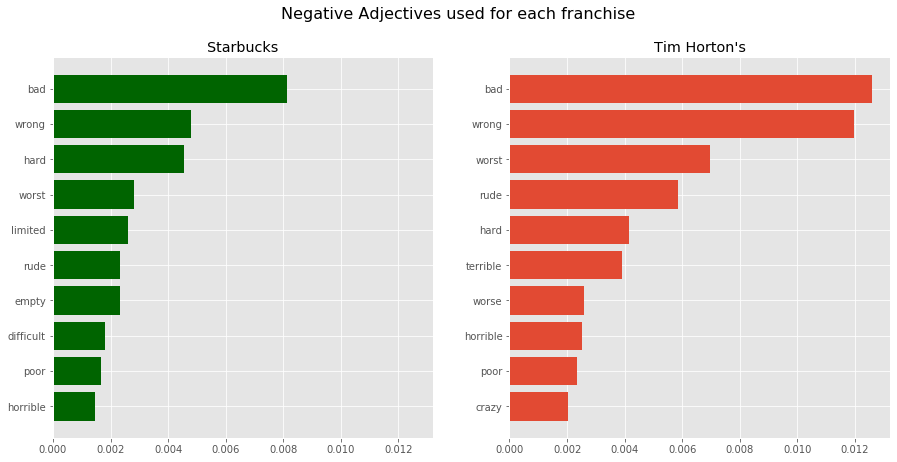

In [509]:
fig, ax = plt.subplots(1, 2, sharex=True)
ax[0].barh([x for x in range(10)][::-1], df_star_neg.head(10).sort_values(by="Ratio", ascending=False)["Ratio"],
          color="darkgreen")
ax[0].set_yticks([x for x in range(10)][::-1])
ax[0].set_yticklabels(df_star_neg.head(10).sort_values(by="Ratio", ascending=False)["Adjective"])
ax[0].set_title("Starbucks")

ax[1].barh([x for x in range(10)][::-1], df_tims_neg.head(10).sort_values(by="Ratio", ascending=False)["Ratio"])
ax[1].set_yticks([x for x in range(10)][::-1])
ax[1].set_yticklabels(df_tims_neg.head(10).sort_values(by="Ratio", ascending=False)["Adjective"])
ax[1].set_title("Tim Horton's")

tit = fig.suptitle("Negative Adjectives used for each franchise", fontsize=16)

Tim Horton's reviews have significantly more occurences of both "bad" and "wrong", which may imply that Tim's do the wrong order more often than Starbucks, and that customers as less satisfied with Tim's. We also see that "rude" occurs more in Tim Horton's reviews. 

Again, this technique does not account for combinations such as "not bad", so this result may be slightly skewed.

Next, let's take a look at the distribution of the sentimentality of the reviews for both franchises. For this analysis, we will be using the compound score as our metric for positivity and negativity. A positive compoud score means that the sentence is generally more positive, and vice versa. More about the compound score can be read [here](https://github.com/cjhutto/vaderSentiment#about-the-scoring).

In [512]:
sia = SIA()
star_sentiments = df_reviews_s["text"].apply(lambda x : sia.polarity_scores(x)["compound"])
tims_sentiments = df_reviews_t["text"].apply(lambda x : sia.polarity_scores(x)["compound"])

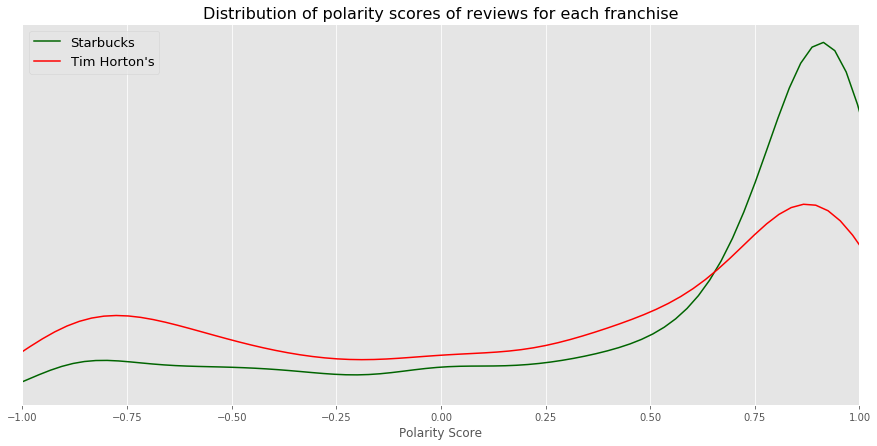

In [745]:
sns.distplot(star_sentiments, bins=20, color="darkgreen", hist=False, label="Starbucks")
sns.distplot(tims_sentiments, bins=20, color="red", hist=False, label="Tim Horton's")
plt.xlim(-1, 1)
plt.yticks([])
plt.xlabel("Polarity Score")
plt.legend(fontsize=13)
tit = plt.title("Distribution of polarity scores of reviews for each franchise", fontsize=16)

From the graph above, we can see that Tim Horton's have a higher ratio of reviews that scored negatively, and Starbucks have a significantly higher ratio of reviews that scored positively. We can take a look at the descriptive statistics to see this more. 

In [533]:
pd.DataFrame({"Starbucks": star_sentiments.describe(), "Tim Horton's": tims_sentiments.describe()})

Starbucks  Tim Horton's
count  2897.000000   1801.000000
mean      0.536438      0.251775
std       0.575377      0.680087
min      -0.990500     -0.995100
25%       0.318200     -0.440400
50%       0.829800      0.493900
75%       0.940200      0.877700
max       0.998200      0.997300

We can see above that the mean and median for Tim's is significantly lower than Starbucks. In fact, a greater majority of starbucks reviews are positive, as the 1st quartile is still positive, whereas the 1st quartile for Tim's is negative. 

We can say from both these analyses that reviewers do not use similar languages to describe Tim's and Starbucks, as people tend to review Tim's less favourably. However, the key adjectives that are used to describe the two are similar. 

On a side note, I'm interested to see the most positive and most negative reviews for both places. Since the reviews are quite long, I won't be showing them. Below is a summary of these reviews: 

1) The most positive review for Starbucks praises their "Clover-brewed" Coffee, yet strangely enough only rates them 4/5. His reasoning is that rude customers bring down the rating. 

2) The most negative review for Starbucks is a customer complaining about the customer service. Interestingly, this review seems to have more words in caps lock than usual. 

3) The most positive review for Tim Horton's is presumably from a tourist. They praised the customer service, and mentioned the history of Tim's as well. They also expressed their love of Canada multiple times. 

4) The most negative review for Tim Horton's is also a customer complaining about the customer service. They even called them "evil people", and remarked that they are a factor to why people kill themselves. 

We can also take a look at reviews from both users who reviewed both Tim Horton's and Starbucks, and make a scatter plot of the polarity scores of the review for each franchise. 

In [553]:
df_reviews_both = df_reviews_s.merge(df_reviews_t, on="user_id", how="inner")

df_reviews_both.rename(columns={"review_id_x" : "Starbucks_review_id", 
                               "business_id_x": "Starbucks_business_id", 
                               "text_x" : "Starbucks_text", 
                               "review_id_y" : "Tims_review_id", 
                               "business_id_y": "Tims_business_id", 
                                "text_y" : "Tims_text"
                               }, inplace=True)



In [572]:
star_sent_both = df_reviews_both["Starbucks_text"].apply(lambda x : sia.polarity_scores(x)["compound"])
tims_sent_both = df_reviews_both["Tims_text"].apply(lambda x : sia.polarity_scores(x)["compound"])

pref = star_sent_both - tims_sent_both

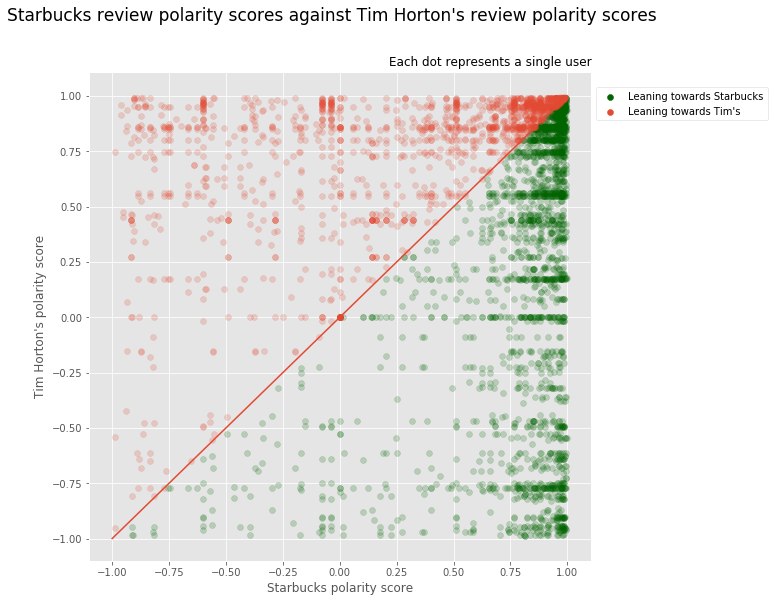

In [583]:
plt.figure(figsize=(9, 9))
plt.scatter(star_sent_both[pref > 0], tims_sent_both[pref > 0], alpha=0.2, color="darkgreen",
            label="Leaning towards Starbucks")
plt.scatter(star_sent_both[pref <=0], tims_sent_both[pref <=0], alpha=0.2,
            label="Leaning towards Tim's")
plt.xlabel("Starbucks polarity score"), plt.ylabel("Tim Horton's polarity score")
plt.suptitle("Starbucks review polarity scores against Tim Horton's review polarity scores", fontsize=17)
plt.plot(np.arange(-1, 1.2, 0.2), np.arange(-1, 1.2, 0.2))

leg = plt.legend(loc=(1.01, 0.9), facecolor="white")
for lh in leg.legendHandles: 
    lh.set_alpha(1)
    
tit = plt.title("Each dot represents a single user", fontsize=12, loc="right")

From the graph above, we can see that there is a greater majority that prefers Starbucks (or at least, reviewed them more favourably) compared to Tim Horton's. The densest area of the plot however is definitely towards the upper right corner, which indicates that they reviewd both Tim Horton's and Starbucks positively. 

### Detecting "Paid Reviewers"

Last but not least, we'll try to see if we can detect paid reviewers.

First, let's see if we can find paid reviews. I have a few ideas on how we can achieve this. 

1) We can check for outliers for the reviews. For example, a 5 star review for a business with a 1.5 star overall rating might be fishy. 

2) We can check the actual review itself for overwhelming positivity, and 0 negative score. We can define "Overwhelmingly positive" and having positive - negative > 0.6, and negative < 0.05. 


Let's first perform number 1. We will create a new dataframe with reviews that are too different compared to the actual rating. We will define "too positive" as a star rating that is +2 away from the overall rating. This has some limitations as the overall rating includes the paid review, however we will go forward with this definition. Also, the thresholds for (2) are arbitrary, so we can optimize these values in the future. 

Reviews that satisfy this definition may not even be paid reviews, since maybe the person's tastes just disagree with the general public, or maybe they had special service. 

In [615]:
business_id = {data[1]["business_id"]: data[1]["stars"] for data in df_GTA.iterrows()}

In [618]:
df_reviews_off = df_reviews_GTA.copy()
df_reviews_off["business_rating"] = df_reviews_off["business_id"].apply(lambda x : business_id[x])

In [620]:
pos_filter = (df_reviews_off["stars"] - df_reviews_off["business_rating"]) >= 2

In [627]:
print("There are {} reviews that differ by +2 from the overall rating, which is {:.3f}% of the total reviews.".format(
    pos_filter.sum(), 
    pos_filter.sum()*100/ df_reviews_off.shape[0]
))

There are 30464 reviews that differ by +2 from the overall rating, which is 3.897% of the total reviews.


We have created a shortlist that is only 4% of the original dataset that might be potential paid reviews. We can see how many of them are 5 star ratings. 

In [633]:
print("There are {} 5-star reviews, which is {:.3f}% of the potential paid reviews.".format(
    (df_reviews_off[pos_filter]["stars"] == 5).sum(), 
    (df_reviews_off[pos_filter]["stars"] == 5).sum() * 100 / pos_filter.sum()
))

There are 27592 5-star reviews, which is 90.572% of the potential paid reviews.


A large majority of the potential paid reviews are 5 star reviews. This makes logical sense, as businesses want to influence the rating as much as possible. 

Next, we can use step 2 to narrow it down even more. 

In [637]:
def get_pos_and_neg(x):
    """
    Get the negative and positive scores of a string x. 
    """
    result = sia.polarity_scores(x)
    return result["pos"], result["neg"]

df_paid = df_reviews_off[pos_filter].copy()
df_paid["pos_neg"] = df_paid["text"].apply(get_pos_and_neg)

In [644]:
THRESHOLD = 0.6
df_really_paid = df_paid[df_paid["pos_neg"].apply(lambda x : (x[0] - x[1] > THRESHOLD) and (x[1] < 0.05))]

print("There are {} reviews that satisfy (2), which is {:.3f}% of the potential paid reviews, and "
      "{:.3f}% of all the GTA reviews.".format(
    df_really_paid.shape[0], 
    df_really_paid.shape[0] * 100 / pos_filter.sum(), 
    df_really_paid.shape[0] * 100 / df_reviews_off.shape[0]
))

There are 202 reviews that satisfy (2), which is 0.663% of the potential paid reviews, and 0.026% of all the GTA reviews.


As we can see, we have narrowed the potential paid reviews by a lot. Let's see one of the reviews that we have identified as being potentially paid with the highest rating difference. 

In [651]:
df_really_paid.loc[(df_really_paid["stars"] - df_really_paid["business_rating"]).idxmax()]["text"]

'Great place!'

What a truly riveting review! Let's take a look at the business that had this review. 

In [659]:
fraud = df_really_paid.loc[(df_really_paid["stars"] - df_really_paid["business_rating"]).idxmax()]["business_id"]
df_GTA[df_GTA["business_id"] == fraud][["name", "stars", "review_count", "is_open"]]

name  stars  review_count  is_open
54542  70 Down    1.5             8        0

Once we have collected our potential paid reviews, we can see who posted the reviews by using the user dataset. 

In [667]:
potential_paid_reviewers = set(df_really_paid["user_id"])
ppr_filter = df_users["user_id"].apply(lambda x : x in potential_paid_reviewers)

In [672]:
df_users[ppr_filter][["name", "yelping_since", "average_stars", "review_count"]].describe()

average_stars  review_count
count     199.000000    199.000000
mean        4.136985     32.236181
std         0.770895    118.918440
min         2.000000      1.000000
25%         3.670000      2.000000
50%         4.200000      7.000000
75%         5.000000     17.000000
max         5.000000   1326.000000

We can see that there the average stars these reviewers give out is generally higher than the average stars of all the users. We can also see that they have written more reviews than usual. This might be due to the smaller sample size, however. 


We can see that the range of reviews vary greatly. There are some who have written only one review, and others who have written over 1000. This might imply that there may be different kinds of paid reviewers:

1) Individual, trust-worthy reviewers (or influencers) who are sponsored by a business to write good reviews. 

2) A group of bot accounts made to review things. 

3) A person who got a discount/ given incentive to write a positive review for the business. 


We can try find reviews and reviewers that satisfy 2) or 3). They generally follow the same pattern: 

* Their reviews are short.

* Their account has very little reviews. 

We will define a short review as having 10 words or less, and little reviews as having written 5 reviews or less. These values are arbitrary and can be modified in the future. 

We can first find the reviews that are short, and then select reviews that are at least slightly positive (compoud score > 0 and rating at least equal to business rating). Then, we can find the users that wrote these reviews, and select accounts that have written 5 reviews or less. 

In [686]:
df_short_reviews = df_reviews_off[df_reviews_off["text"].apply(lambda x : len(x.split(" ")) <= 10)]

In [690]:
df_short_pos_reviews = df_short_reviews[df_short_reviews["text"].apply(
    lambda x : sia.polarity_scores(x)["compound"] > 0)]

In [692]:
filter_ = (df_short_pos_reviews["stars"] - df_short_pos_reviews["business_rating"]) >= 0

In [696]:
df_spr = df_short_pos_reviews[filter_].copy()

In [698]:
print("There are {} positive reviews with 10 words or less, which is {:.3f}% of the total reviews.".format(
    df_spr.shape[0], 
    df_spr.shape[0] * 100 / df_reviews_off.shape[0]
))

There are 1637 positive reviews with 10 words or less, which is 0.209% of the total reviews.


Let's take a look at an example of the above. 

In [713]:
df_spr.sample(1, random_state = 270).iloc[0]["text"]

'Fresh juices, no additives or sugars. Fun and friendly service'

It definitely does look very artificial, as it can be easily mistaken for a tagline or advertisement. 

In [700]:
spr_user_ids = set(df_spr["user_id"])
spr_users = df_users[df_users["user_id"].apply(lambda x : x in spr_user_ids)].copy()

In [701]:
sprb_users = spr_users[spr_users["review_count"] <= 5]

In [705]:
sprb_users.head()[["name", "review_count", "friends", "average_stars"]]

name  review_count  \
22779   Sritam             1   
67573    Dulka             3   
69299  Jingwei             4   
71954    Varya             4   
84282     Zach             3   

                                                 friends  average_stars  
22779  vQFF_cqsTTOIb2dYXLP6zw, 3_4crdqwrpAX0aVCv_-MmQ...           5.00  
67573  Ib4i6ytS4Sa0HlHRWkzqTw, V9nMlXoUMsnM5JMiEtEblA...           2.33  
69299  CgP4zychLF7c_xXQ10XNEA, eLEUKpvEe69KGcs5qSI38A...           4.00  
71954  llMfzFha1fm6ANVJvJImPA, wuUNeaARLRwjSLIayWGD-g...           3.75  
84282  hI3OCaXW63_AgmMIha79Lg, KNT0jAdYTkjrV-H56jK84g...           2.33

Above is an example of the users that we found. We can also further narrow down potential bots/paid customers with the number of friends. People who make an account just to write a review to get a discount should have no friends, as the account is freshly created.

In [709]:
print("There are {} accounts that have no friends that satisfy the the filters.".format(
    sprb_users[sprb_users["friends"] == "None"].shape[0]
))

There are 223 accounts that have no friends that satisfy the the filters.


In conclusion, I believe that although it is not perfect, we do have some capability of detecting paid reviewers and paid reviews. Given more data, we can even train a machine learning model to notify staff of potentially fake reviews. Yelp also gives users the ability to flag reviews, so that may help create training datasets for the model. However, I think that human intervention is still needed, and it is hard to fully autotomize the detection of fake reviews. 

## Conclusion

After a long journey, we state all the findings that we have discovered: 

1) The ratio of Mexican restaurants in Arizona is higher than usual. 

2) Restaurants are the most frequent category by a huge margin, and a large number of Restaurants are Nightlife/Bars. 

3) There is no overall correlation with bike parking and star rating.

4) Northern areas have a higher ratio of businesses that offer bike parking

5) There is a small correlation with price rating and bike parking. The higher the price rating, the less likely it is to have bike parking. 

6) There is no conclusion to the claim that having more yelp reviews lead to higher ratings and thus more sales.

7) Downtown areas are more likely to have higher ratings and more reviews. 

8) In the downtown area, it is very likely that there is a Starbucks nearby for every Tim's. 

9) A small number of users are responsible for a majority of the reviews. The distribution follows the Pareto Principle. 

10) The language used for starbucks is generally more positive compared to the language used for Tim Horton's. 

11) We can narrow down on potential paid reviewers, however it is very difficult to do so automatically and realistically, we always need human intervention. 



That was a long journey! Thank you for reading this report, and I hope you found this analysis as interesting as I did. 